In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import r2_score
import random
from scipy.signal import savgol_filter
from sklearn.metrics import mean_squared_error
from scipy.signal import savgol_filter

In [ ]:
# Function to estimate log-normal distribution parameters from mean and median
def estimate_lognormal_params(mean, median):
    sigma = np.sqrt(2 * np.log(mean / median))
    mu = np.log(median)
    return mu, sigma

# Function to generate synthetic data using log-normal distribution and clip to observed range
def generate_lognormal_samples(mean, median, min_val, max_val, size=5000):
    mu, sigma = estimate_lognormal_params(mean, median)
    samples = np.random.lognormal(mean=mu, sigma=sigma, size=size)
    return np.clip(samples, min_val, max_val)


def generate_time (t_initial, t_final, n_timesteps):
    t_numpy = np.linspace(t_initial, t_final, n_timesteps)
    t_reshape = t_numpy.reshape(1, -1)
    t_torch = torch.tensor(t_reshape, dtype=torch.float32).to(device)
    return t_numpy, t_reshape, t_torch

def smooth_peak(curve, window_length=11, polyorder=3, baseline_ratio=0.01):
    curve = np.asarray(curve)
    smoothed = savgol_filter(curve, window_length=window_length, polyorder=polyorder)

    peak_idx = np.argmax(smoothed)
    peak_val = smoothed[peak_idx]
    threshold = peak_val * baseline_ratio

    # Find start (left of peak)
    start_idx = 0
    for i in range(peak_idx, 0, -1):
        if smoothed[i] < threshold:
            start_idx = i
            break

    # Find end (right of peak)
    end_idx = len(curve) - 1
    for i in range(peak_idx, len(curve)):
        if smoothed[i] < threshold:
            end_idx = i
            break

    # Keep only the main peak region
    cleaned = np.zeros_like(curve)
    cleaned[start_idx:end_idx + 1] = curve[start_idx:end_idx + 1]

    return cleaned

def zscore(x, eps=1e-12):
    x = np.asarray(x, dtype=float)
    mu = x.mean()
    sd = x.std()
    if sd < eps:
        return x * 0.0
    return (x - mu) / sd

def best_lag_correlation(a, b, max_lag=None, normalize='zscore'):

    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)

    T = min(len(a), len(b))
    a = a[:T]
    b = b[:T]

    if normalize == 'zscore':
        a_n = zscore(a)
        b_n = zscore(b)
    else:
        a_n = a
        b_n = b

    if max_lag is None:
        max_lag = T - 1

    best_corr = -np.inf
    best_lag = 0
    best_pair = (None, None)

    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:

            a_slice = a_n[-lag:]
            b_slice = b_n[:T+lag]
        elif lag > 0:

            a_slice = a_n[:T-lag]
            b_slice = b_n[lag:]
        else:
            a_slice = a_n
            b_slice = b_n

        if len(a_slice) < 2:
            continue
        corr = np.dot(a_slice, b_slice) / (len(a_slice) - 1)

        if corr > best_corr:
            best_corr = corr
            best_lag = lag
            if lag < 0:
                a_raw = a[-lag:]
                b_raw = b[:T+lag]
            elif lag > 0:
                a_raw = a[:T-lag]
                b_raw = b[lag:]
            else:
                a_raw = a
                b_raw = b
            best_pair = (a_raw, b_raw)

    return {'lag': best_lag, 'corr': best_corr, 'a_seg': best_pair[0], 'b_seg': best_pair[1]}

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Generate synthetic values for each variable
mass     = generate_lognormal_samples(mean=9.62,     median=2.81,     min_val=0.0404,    max_val=108.86)
area     = generate_lognormal_samples(mean=224.82,   median=17.09,    min_val=0.98,      max_val=4931.81)
velocity = generate_lognormal_samples(mean=0.51,     median=0.40,     min_val=0.04,      max_val=1.58)
distance = generate_lognormal_samples(mean=46162.12, median=29611.86, min_val=35.41,     max_val=294509.22)
dispersion = generate_lognormal_samples(mean=130.73,     median=37.48,     min_val=1.9,      max_val=1486.45)

In [ ]:
# Linear scale and reshape
M = mass.reshape(-1,1)
A = area.reshape(-1,1)
x = distance.reshape(-1,1)
u = velocity.reshape(-1,1)
Q = np.array(A*u)
Q = Q.reshape(-1,1)
R= 1
theta = 1
D = dispersion.reshape(-1,1)

In [ ]:
n_timesteps = 100000
t_numpy, t_reshape, t_torch = generate_time(1, 3e6, n_timesteps)
c_downstream_filter = (1e6 * M) / (2 * theta * A * R * np.sqrt(np.pi * D * t_reshape/ R)) * np.exp(-((x - u * t_reshape / R) ** 2) / (4 * D * t_reshape / R))

In [ ]:
t_peak = []
max_concentrion_array = []
for i in range (c_downstream_filter.shape[0]):
  max_concentrion_idx = np.argmax(c_downstream_filter[i,:])
  max_concentrion = np.max(c_downstream_filter[i,:])
  time_peak = t_reshape[:,max_concentrion_idx]
  t_peak = np.append(t_peak,time_peak)
  max_concentrion_array = np.append(max_concentrion_array,max_concentrion)

v = distance/t_peak
pe = (distance*velocity)/dispersion
valid_v = (v >= 0.1) & (v <= 6)
valid_pe = (pe >= 10) & (pe <= 1500)
valid_max_c = (max_concentrion_array >= 0.3) & (max_concentrion_array <= 3000)
valid_ratio =  valid_v & valid_pe & valid_max_c

In [ ]:
# Linear scale and reshape
valid_M = M[valid_ratio]
valid_M = valid_M[0:3500]
valid_A = A[valid_ratio]
valid_A = valid_A[0:3500]
valid_x = x[valid_ratio]
valid_x = valid_x[0:3500]
x_upstream = np.array(valid_x/ 10)
x_upstream = x_upstream.reshape(-1,1)
valid_u = u[valid_ratio]
valid_u = valid_u[0:3500]
valid_D = D[valid_ratio]
valid_D = valid_D[0:3500]
valid_Q = np.array(valid_A*valid_u)

In [ ]:
# Calculate upstream and downstream BTCs using ADE analytical solution
c_upstream = (1e6 * valid_M) / (2 * theta * valid_A * R * np.sqrt(np.pi * valid_D * t_reshape / R)) * np.exp(-((x_upstream - valid_u * t_reshape / R) ** 2) / (4 * valid_D * t_reshape / R))

c_downstream = (1e6 * valid_M) / (2 * theta * valid_A * R * np.sqrt(np.pi * valid_D * t_reshape/ R)) * np.exp(-((valid_x - valid_u * t_reshape / R) ** 2) / (4 * valid_D * t_reshape / R))

In [ ]:
# Calculate truncation time
ratios =[]
for i in range(c_downstream.shape[0]):
  max_concentrion_idx = np.nanargmax(c_downstream[i,:])
  time_peak = t_numpy[max_concentrion_idx]
  time_max = np.max(t_numpy)
  ratio = time_max/time_peak
  ratios = np.append(ratios,ratio)
ratios = ratios.reshape(-1,1)

In [ ]:
very_low_quality = []
low_quality = []
medium_quality = []
high_quality = []
very_high_quality = []

# Separate by quality range
for i in range(len(ratios)):
  if ratios[i] < 2:
    very_low_quality.append(ratios[i])
  elif ratios[i] < 5:
    low_quality.append(ratios[i])
  elif ratios[i] < 10:
    medium_quality.append(ratios[i])
  elif ratios[i] < 20:
    high_quality.append(ratios[i])
  else:
    very_high_quality.append(ratios[i])

In [ ]:
t_max = []
t_peak = []
c_downstream_train = c_downstream[0:2500,:]

c_upstream_train = c_upstream[0:2500,:] # input
c_downstream_truncated = c_downstream_train.copy() # target

c_upstream_test = c_upstream[2501:,:] # input for test non truncated
c_downstream_test = c_downstream[2501:,:] # target for test non truncated

for i in range(c_downstream_train.shape[0]):
    # Find peak index and time
    c_peak_idx = np.argmax(c_downstream[i])
    t_peak_val = t_numpy[c_peak_idx]
    t_peak.append(t_peak_val)

    # Determine truncation point (t_max_idx)
    t_max_idx = int(1.2 * c_peak_idx)
    t_max.append(t_numpy[t_max_idx] if t_max_idx < len(t_numpy) else t_numpy[-1])  # optional

    # Truncate curve until t_max_idx
    truncated = c_downstream[i, :t_max_idx]

    # Get value to pad
    c_last = 0
    # Create flat padding array of the same dtype
    pad_length = c_downstream.shape[1] - t_max_idx
    padding = np.full(pad_length, c_last, dtype=truncated.dtype)

    # Concatenate truncated + padding
    full_curve = np.concatenate([truncated, padding])

    # Save back to copy
    c_downstream_truncated[i] = full_curve


In [ ]:
print(c_downstream_truncated.shape)

(2500, 100000)


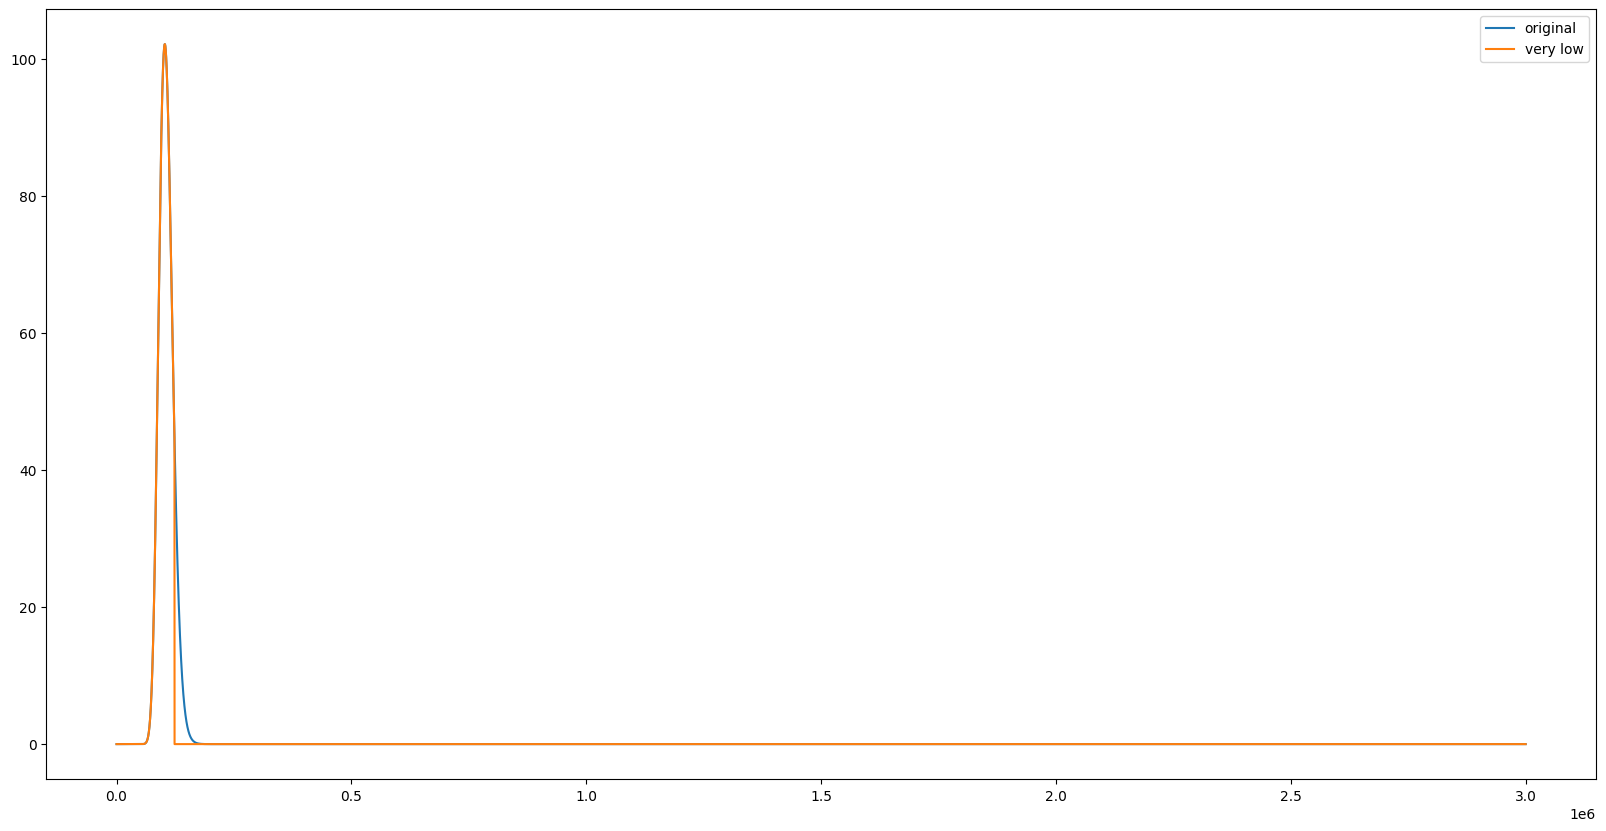

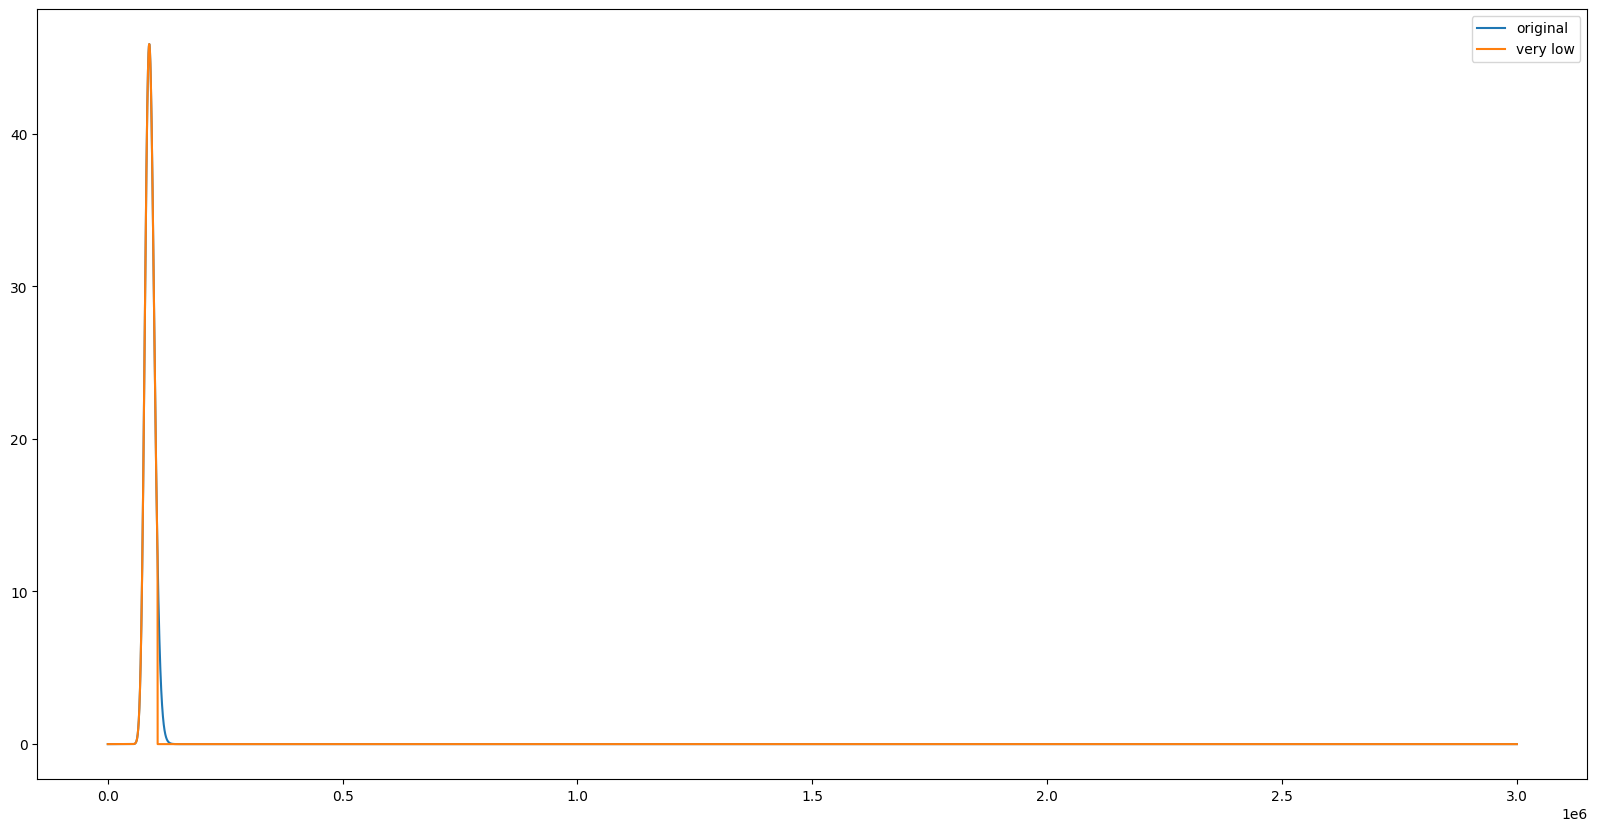

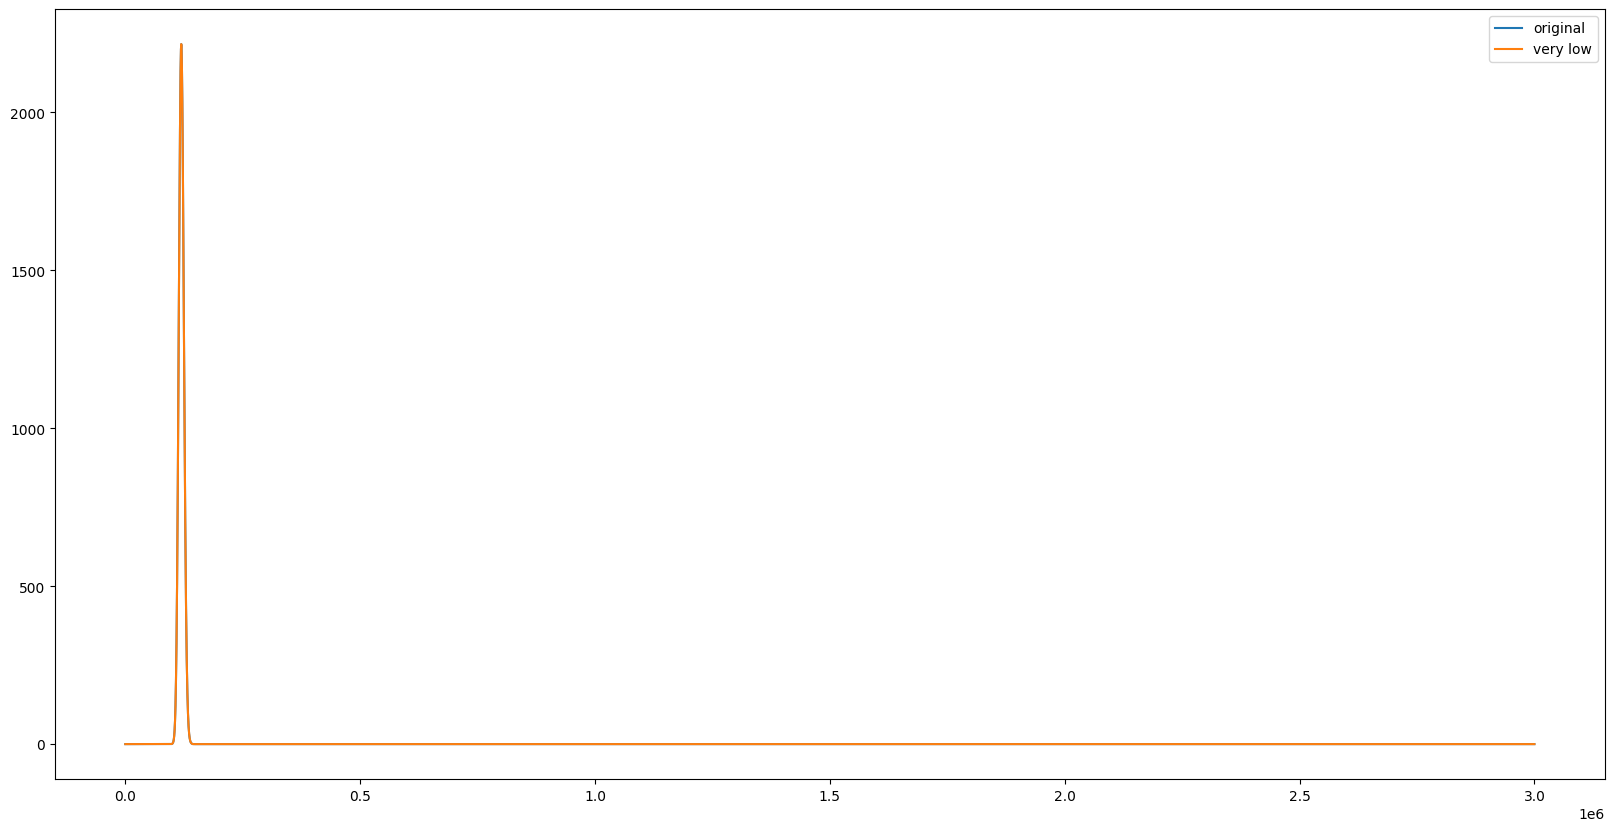

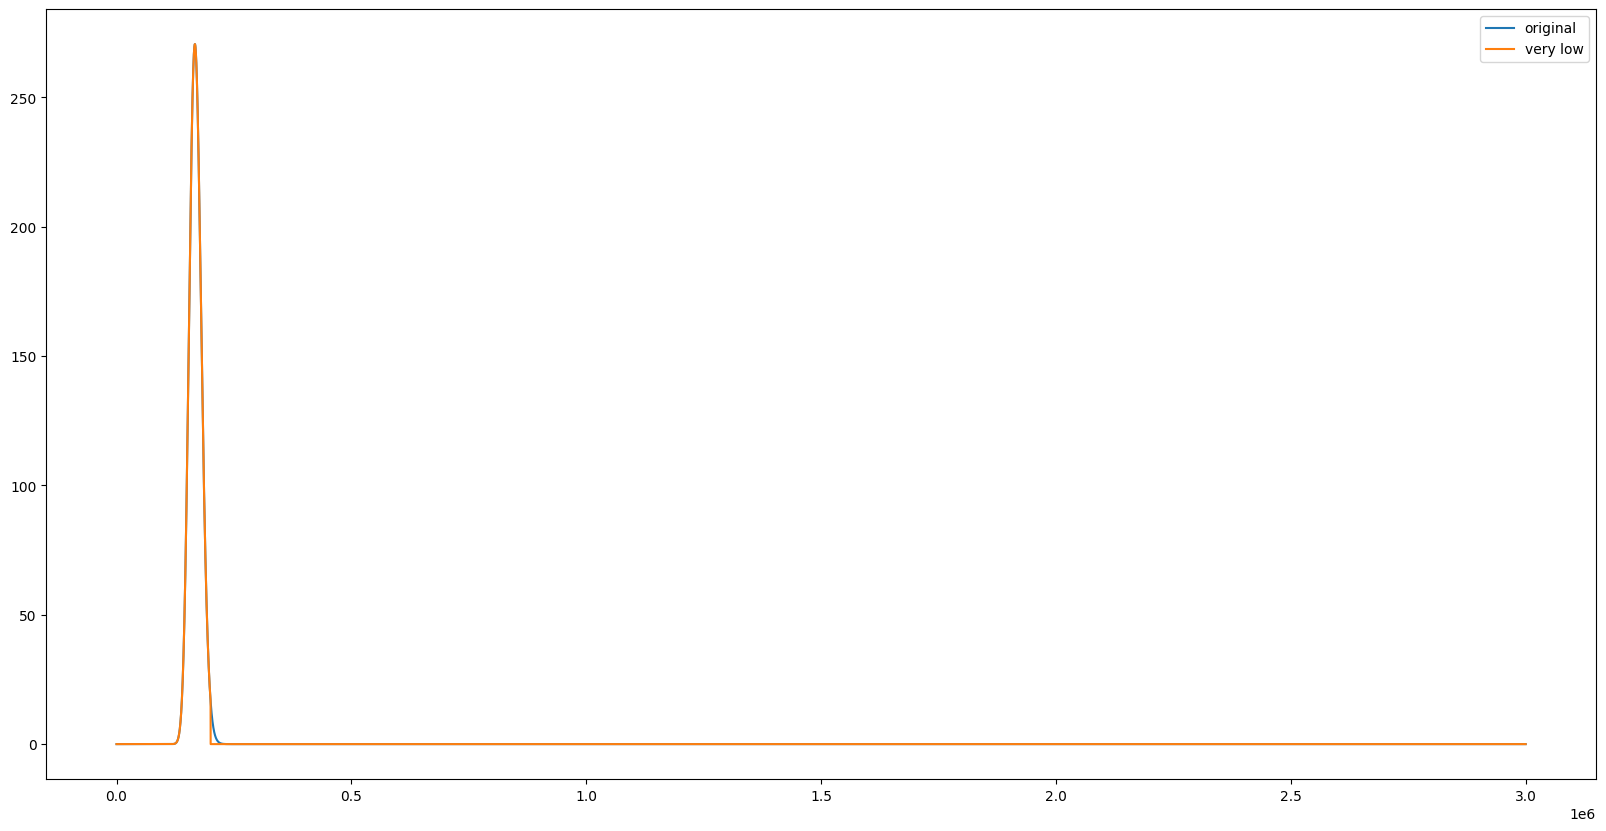

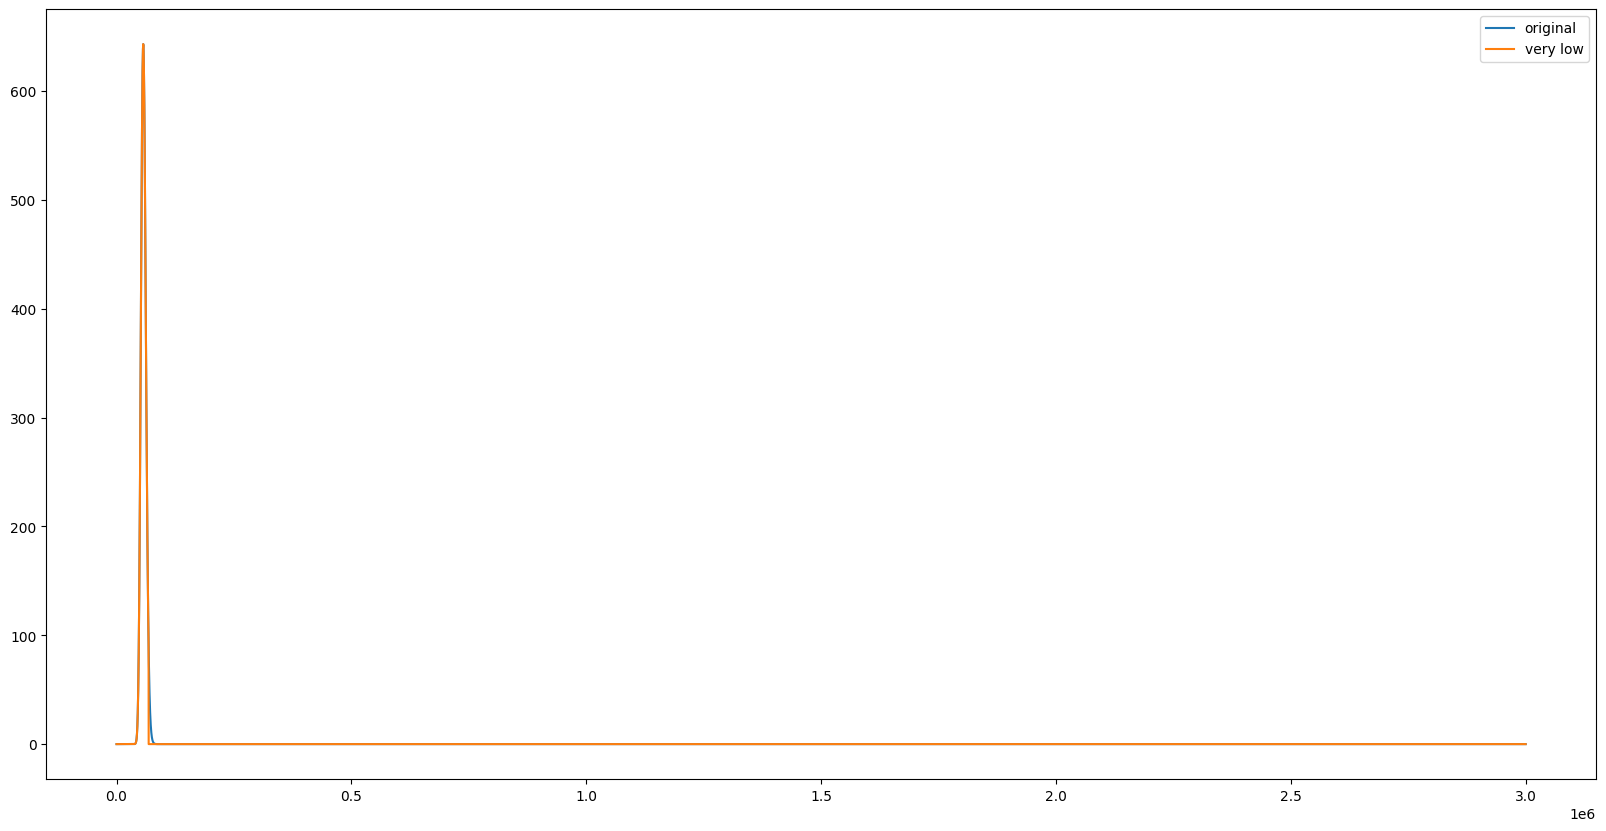

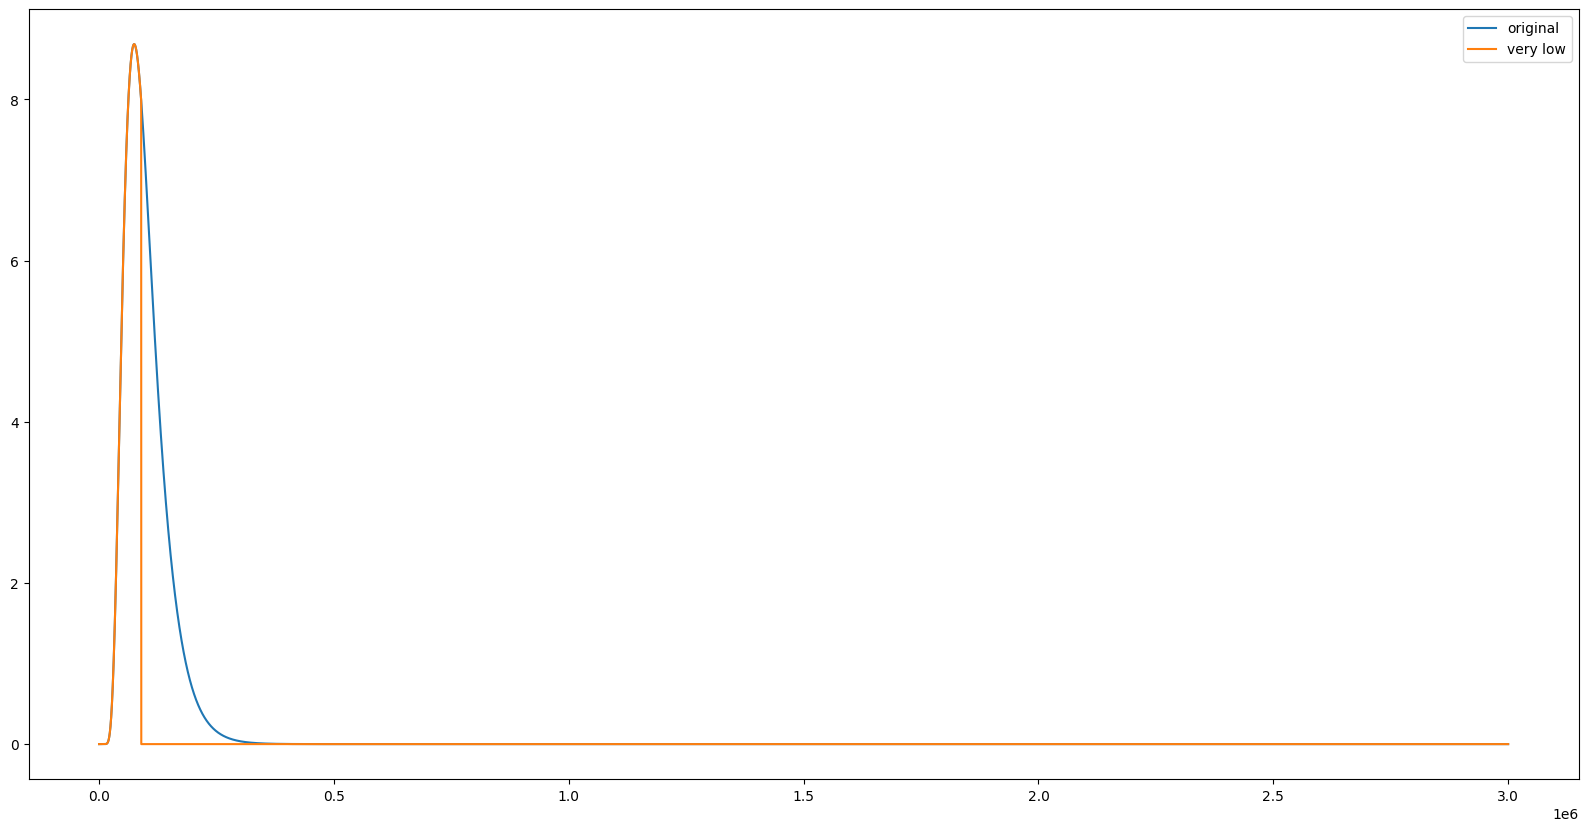

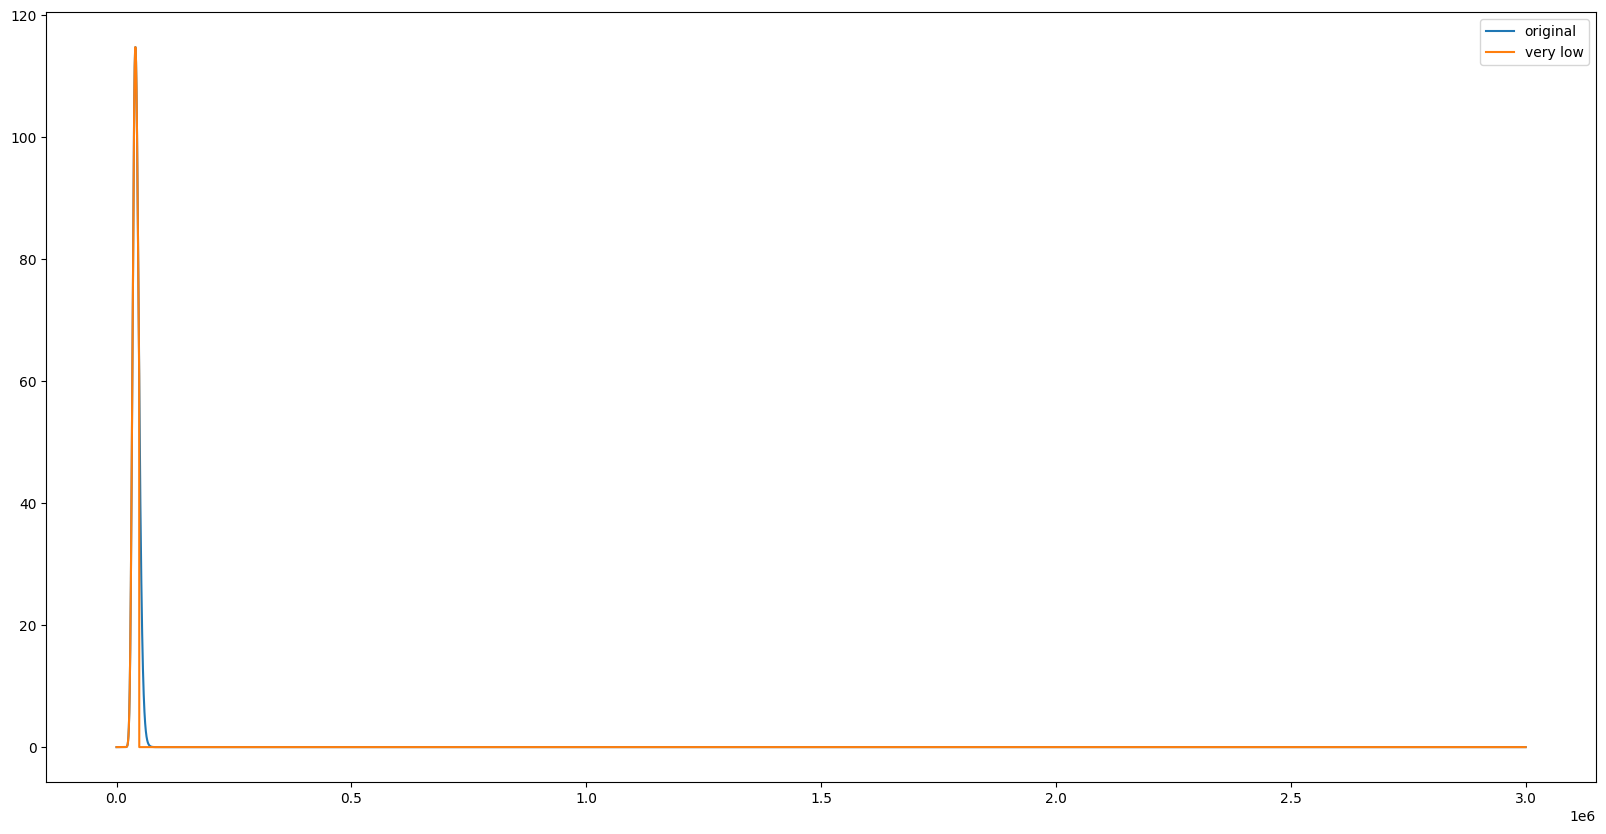

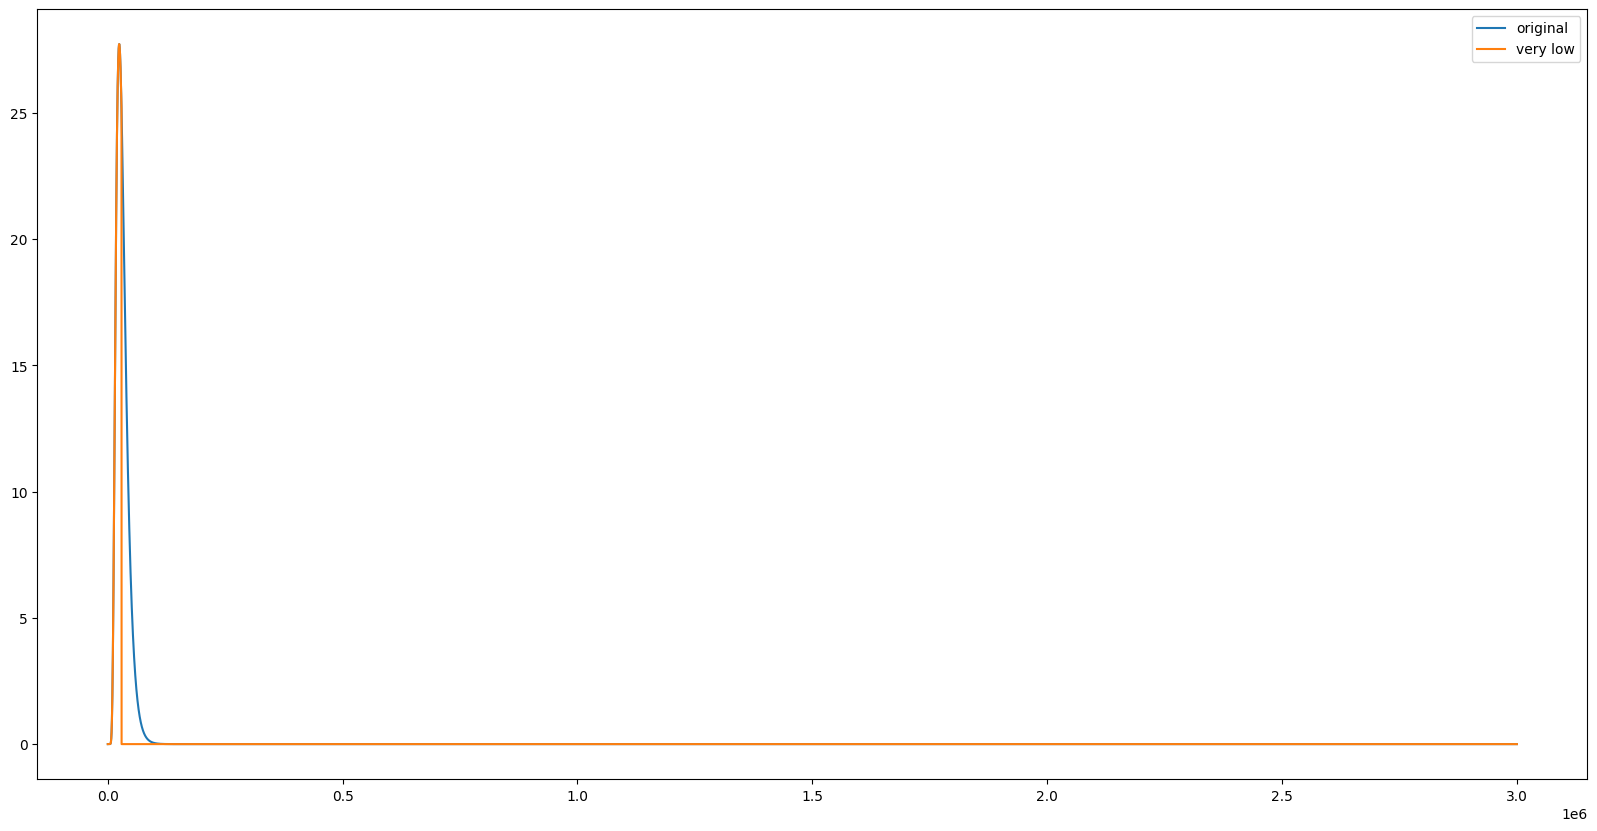

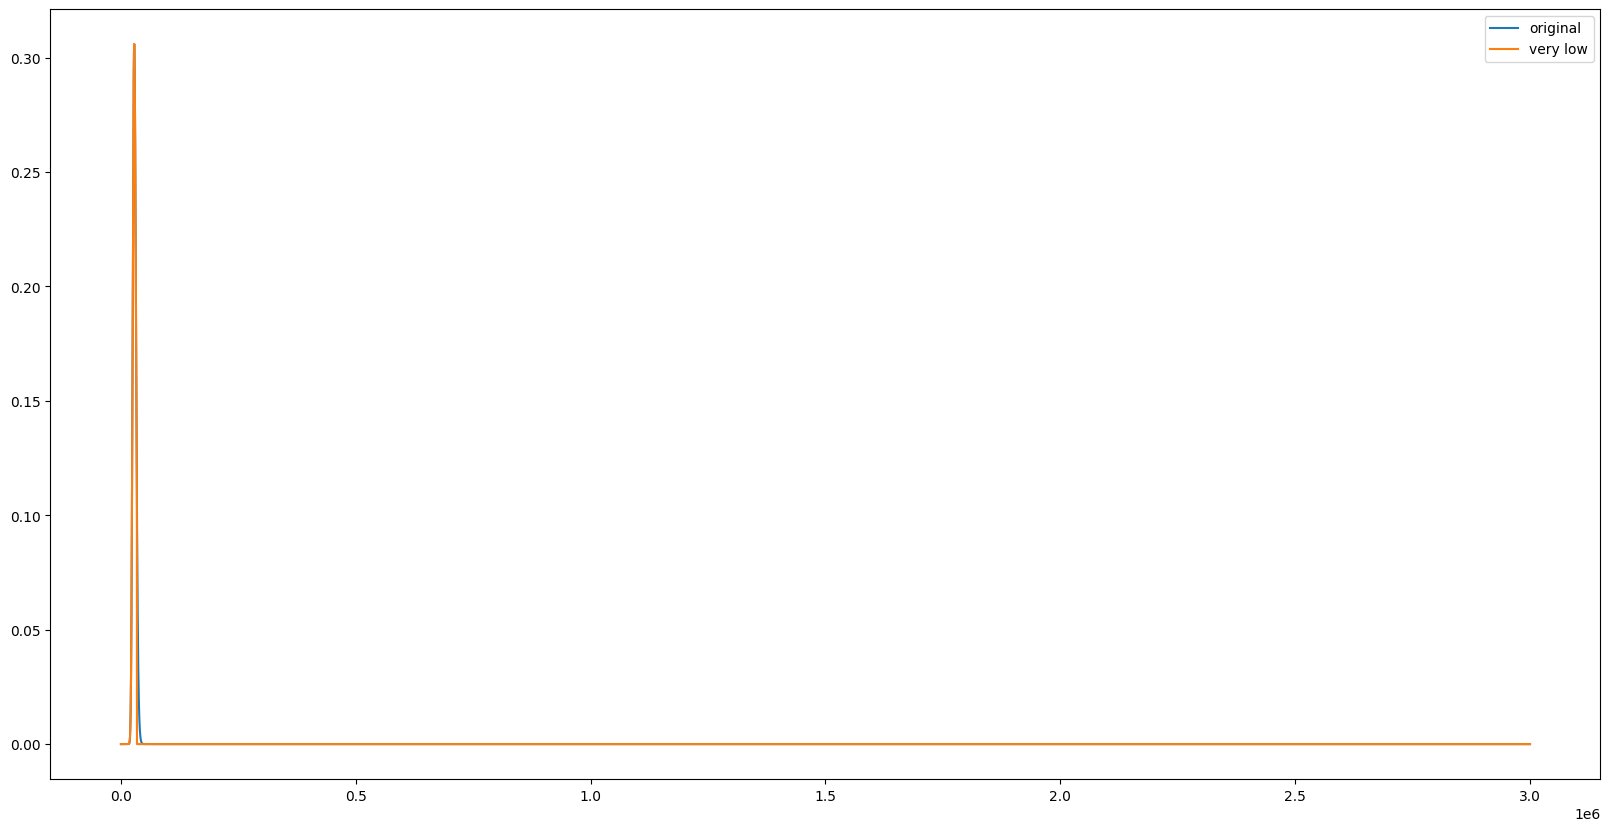

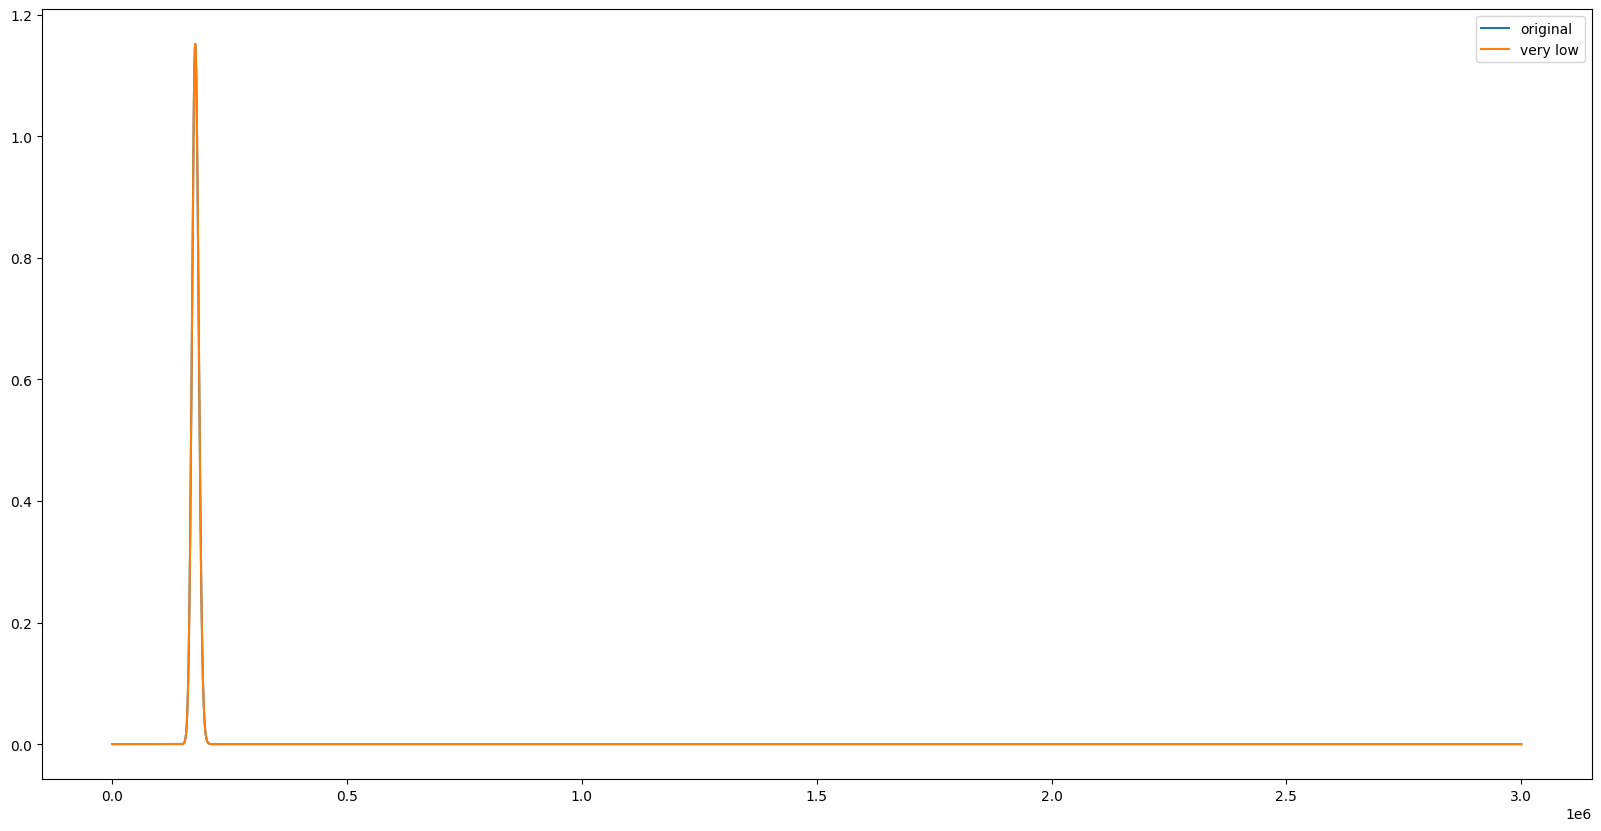

In [ ]:
for i in range(10):
  plt.figure(figsize=(20,10))
  plt.plot(t_numpy,c_downstream[i,:],label = 'original')
  plt.plot(t_numpy,c_downstream_truncated[i,:], label = 'very low')
  plt.legend()
  plt.show()

In [ ]:
dtype = torch.float32
X = torch.tensor(np.array(c_upstream_train)).to(device, dtype)
y = torch.tensor(np.array(c_downstream_truncated)).to(device,dtype)

x_test_nontruncated = torch.tensor(np.array(c_upstream_test)).to(device, dtype)
y_test_nontruncated = torch.tensor(np.array(c_downstream_test)).to(device,dtype)

In [ ]:
dataset = TensorDataset(X, y)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size


train_dataset, test_dataset, val_dataset = random_split(dataset, [train_size, test_size, val_size])
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 2048),
            nn.ReLU(),

            nn.Linear(2048, 1024),
            nn.ReLU(),

            nn.Linear(1024, output_size)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Model, loss, optimizer
input_size = X.shape[1]
output_size = y.shape[1]
model = MLP(input_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)

In [ ]:
# Lists to store training and validation losses
train_losses = []
val_losses = []

epochs = 800  # Set number of epochs

for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0  # Track training loss

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()

    # Compute average training loss for this epoch
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)  # Store training loss

    # Print training loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Training Loss: {avg_train_loss:.6f}')

    # Validation step every 30 epochs
    if epoch % 30 == 0:
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append((epoch, avg_val_loss))

        print(f'Epoch {epoch}, Validation Loss: {avg_val_loss:.6f}')

Epoch 0, Training Loss: 742.814707
Epoch 0, Validation Loss: 690.102224
Epoch 30, Validation Loss: 417.181261
Epoch 60, Validation Loss: 372.495934
Epoch 90, Validation Loss: 251.078104
Epoch 100, Training Loss: 318.567382
Epoch 120, Validation Loss: 395.733753
Epoch 150, Validation Loss: 274.384146
Epoch 180, Validation Loss: 309.089484
Epoch 200, Training Loss: 302.024477
Epoch 210, Validation Loss: 270.330684
Epoch 240, Validation Loss: 237.853583
Epoch 270, Validation Loss: 254.338034
Epoch 300, Training Loss: 281.527117
Epoch 300, Validation Loss: 247.368573
Epoch 330, Validation Loss: 239.613767
Epoch 360, Validation Loss: 226.325004
Epoch 390, Validation Loss: 263.208097
Epoch 400, Training Loss: 271.733751
Epoch 420, Validation Loss: 220.303279
Epoch 450, Validation Loss: 216.147560
Epoch 480, Validation Loss: 193.044400
Epoch 500, Training Loss: 147.758594
Epoch 510, Validation Loss: 199.309653
Epoch 540, Validation Loss: 176.909153
Epoch 570, Validation Loss: 152.533176
Epoch

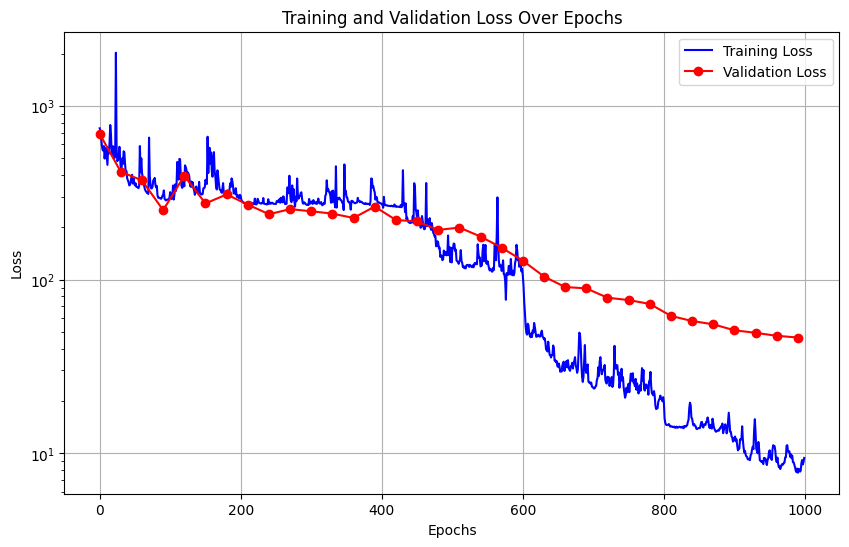

In [ ]:
# Extract epochs and validation losses for plotting
val_epochs, val_loss_values = zip(*val_losses)  # Unpack stored validation losses

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.semilogy(range(epochs), train_losses, label='Training Loss', color='blue')
plt.semilogy(val_epochs, val_loss_values, label='Validation Loss', color='red', marker='o')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Test with truncated data
model.eval()

actual_curves = []
predicted_curves = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)

        # Move data to CPU for plotting
        actual_curves.extend(batch_y.cpu().numpy())
        predicted_curves.extend(outputs.cpu().numpy())

actual_curves = np.array(actual_curves)
predicted_curves = np.array(predicted_curves)
predicted_curves[predicted_curves < 0] = 0

In [ ]:
max_lag = 100
use_normalize = 'zscore'

cc_results = []
for i in range(actual_curves.shape[0]):
    a = actual_curves[i]
    b = smooth_peak(predicted_curves[i])
    res = best_lag_correlation(a, b, max_lag=max_lag, normalize=use_normalize)
    cc_results.append(res)

cc_mean_corr = np.mean([r['corr'] for r in cc_results])
print(f"[Cross-Correlation] Correlación media (al mejor lag): {cc_mean_corr:.4f}")

all_lags = [res['lag'] for res in cc_results]
all_corrs = [res['corr'] for res in cc_results]

all_lags = np.array(all_lags)
all_corrs = np.array(all_corrs)

print("Lags:", all_lags[:5])
print("Correlaciones:", all_corrs[:5])

[0.9860830307006836, 0.9905388355255127, 0.9866197109222412, 0.9932325482368469, 0.9584622383117676, 0.9853017926216125, 0.6300122737884521, 0.989265501499176, 0.9990173578262329, 0.8335461616516113, 0.568321943283081, 0.9678133726119995, 0.9178630709648132, 0.9647995829582214, 0.9754840135574341, 0.9641410708427429, 0.9614798426628113, 0.99483722448349, 0.9556218385696411, 0.9891684055328369, 0.9956084489822388, 0.9839444160461426, 0.992636501789093, 0.8927649855613708, 0.967147946357727, 0.9724955558776855, 0.9958633184432983, 0.9783956408500671, 0.9930429458618164, 0.9367412328720093, 0.9901258945465088, 0.9126886129379272, 0.9932583570480347, 0.9563453793525696, 0.9640027284622192, 0.913009762763977, 0.9825128316879272, 0.9640381336212158, 0.9652166962623596, 0.9742980599403381, 0.9723159670829773, 0.9290697574615479, 0.9083646535873413, 0.9856534600257874, 0.9644250869750977, 0.978430986404419, 0.9980952739715576, 0.9308744668960571, 0.9611599445343018, 0.915107786655426, 0.886651

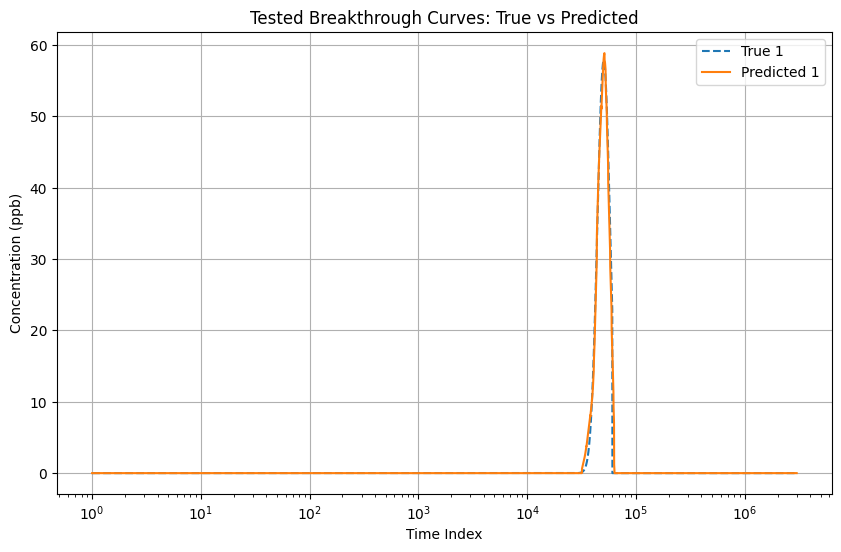

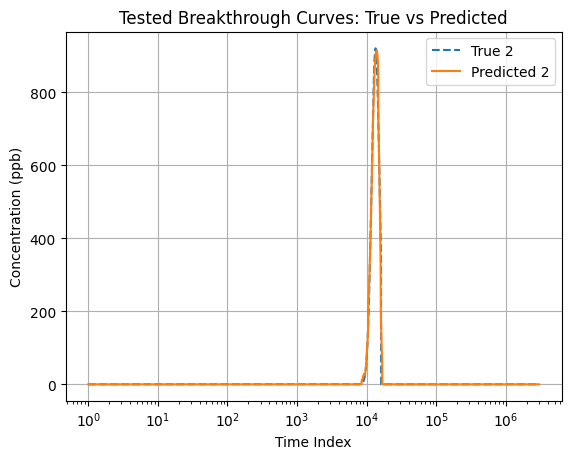

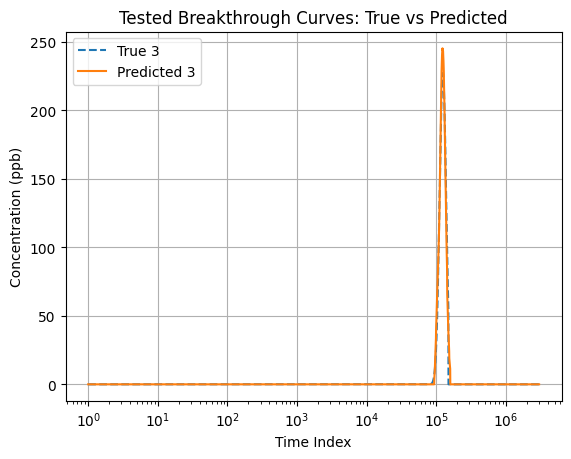

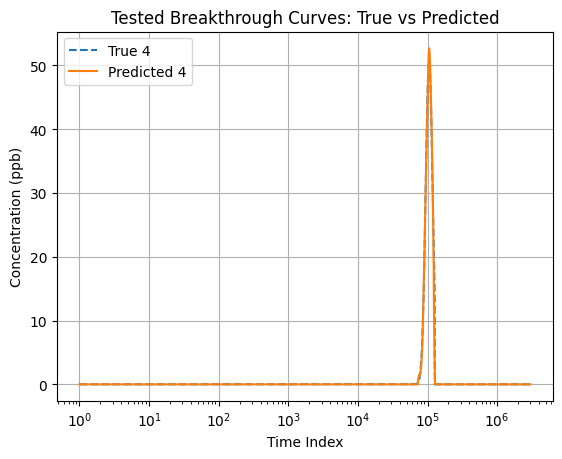

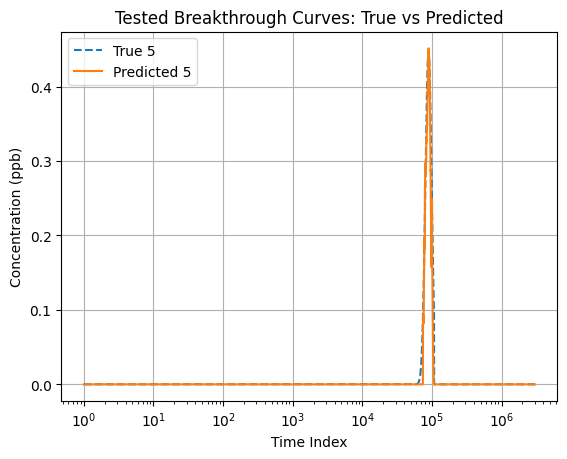

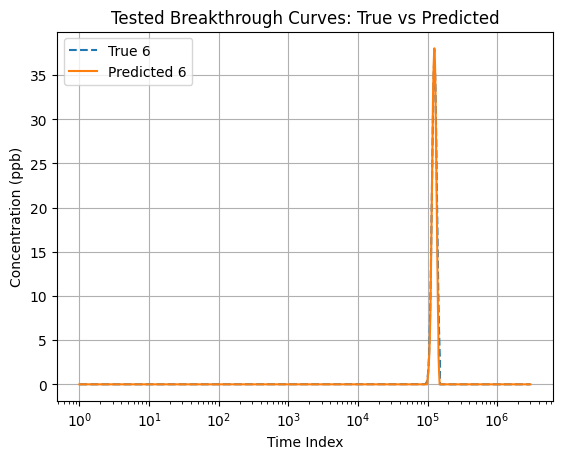

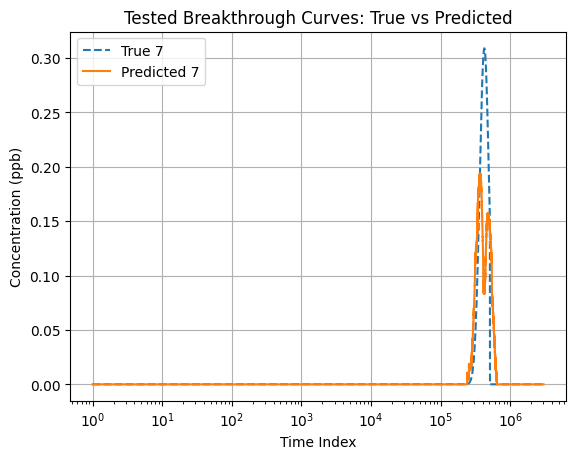

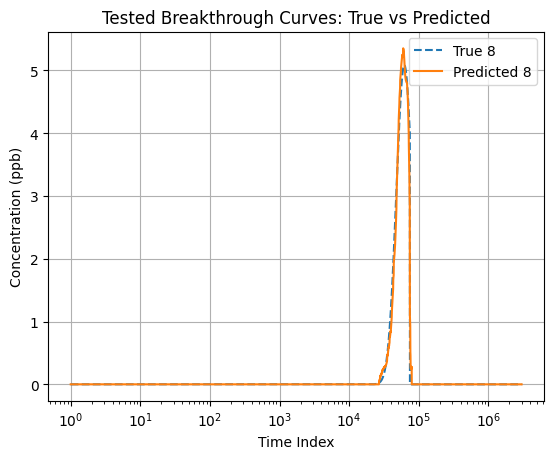

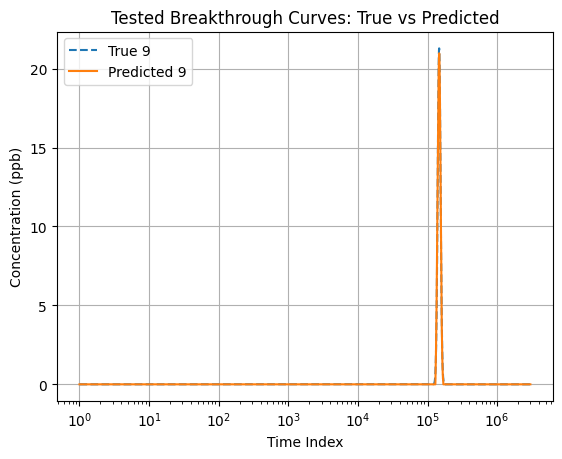

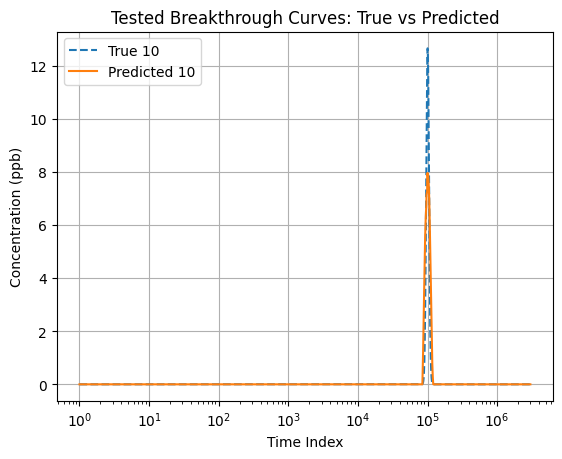

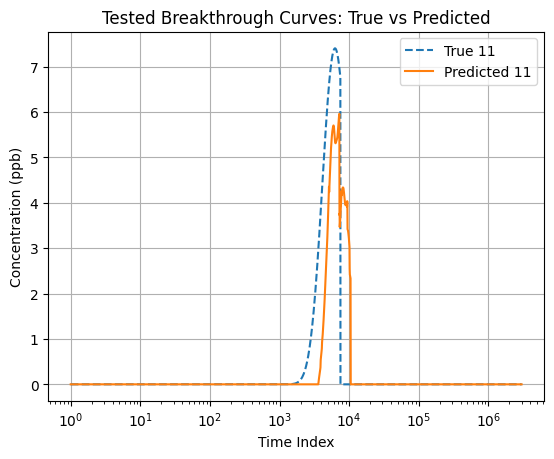

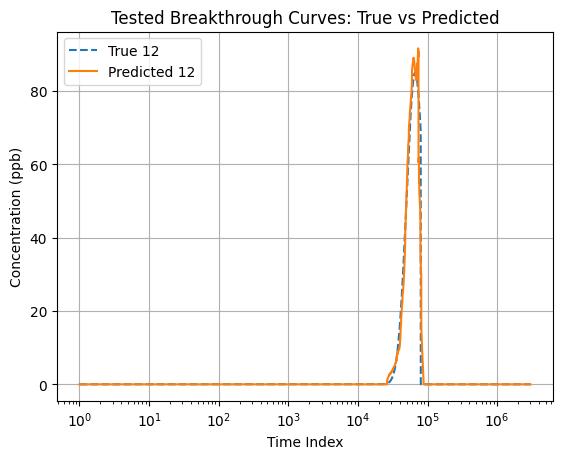

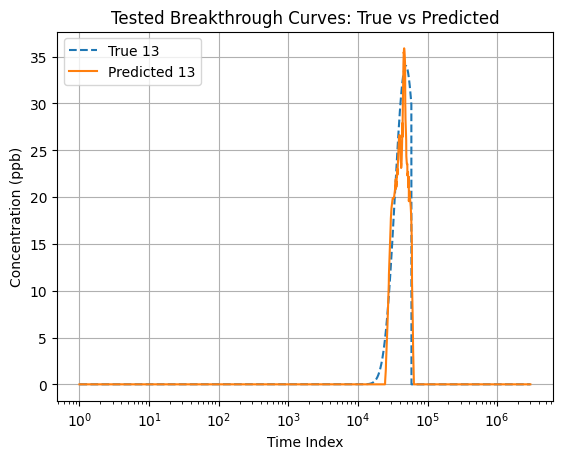

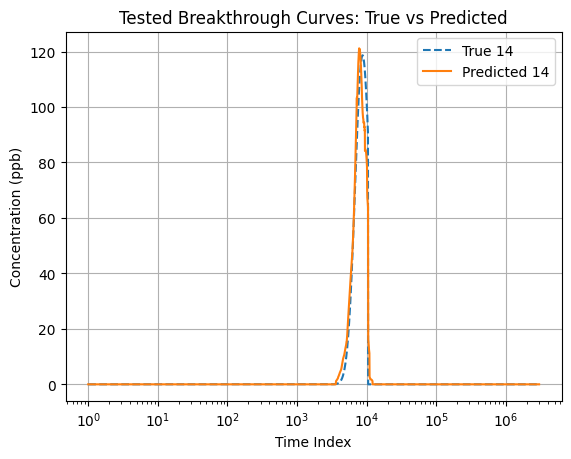

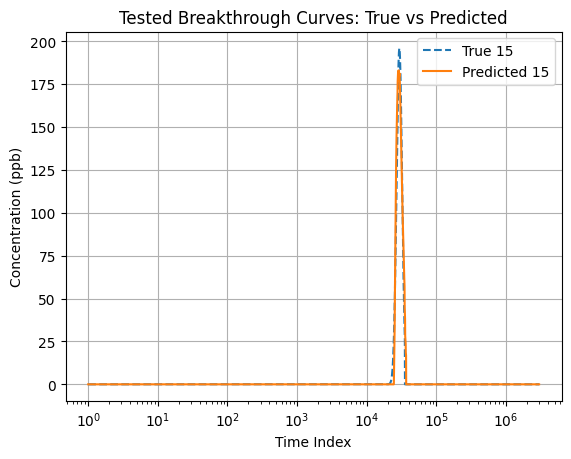

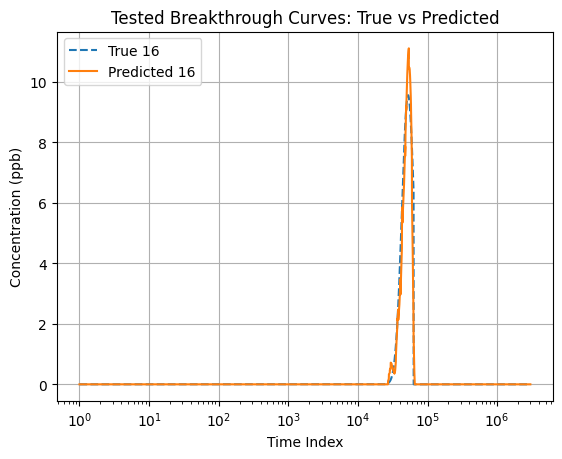

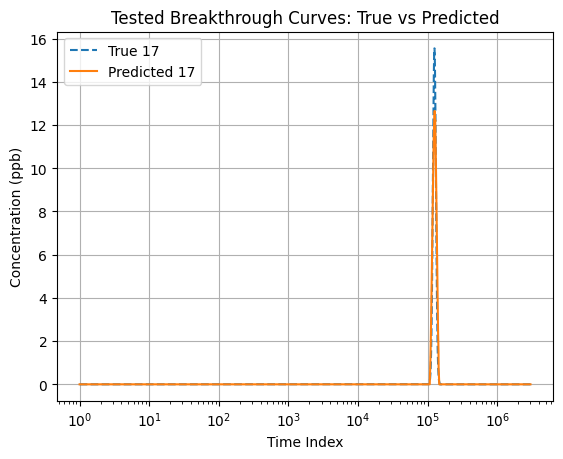

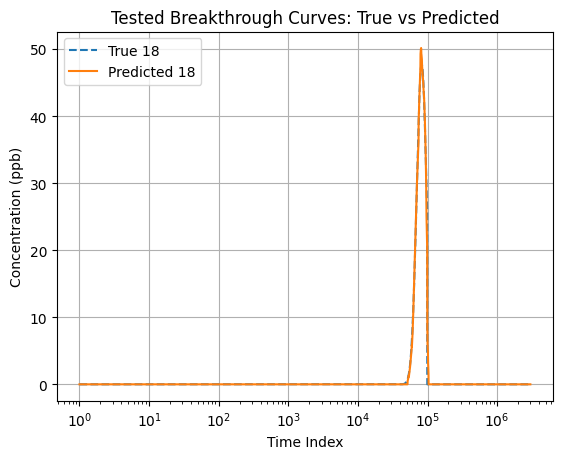

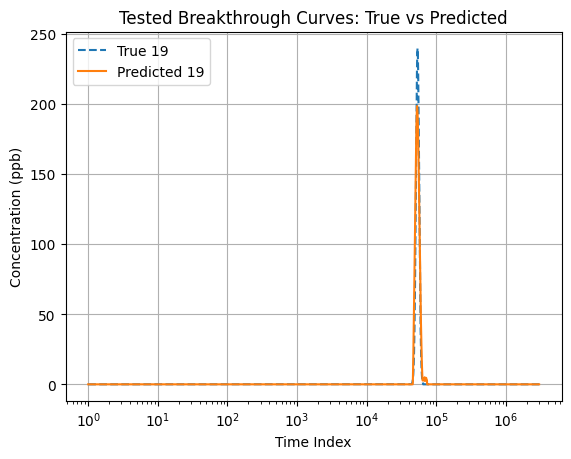

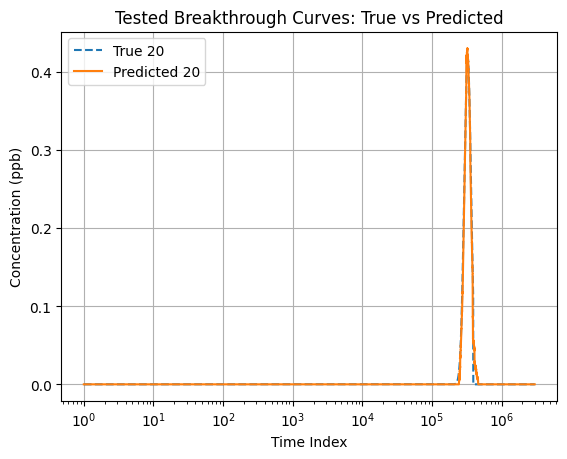

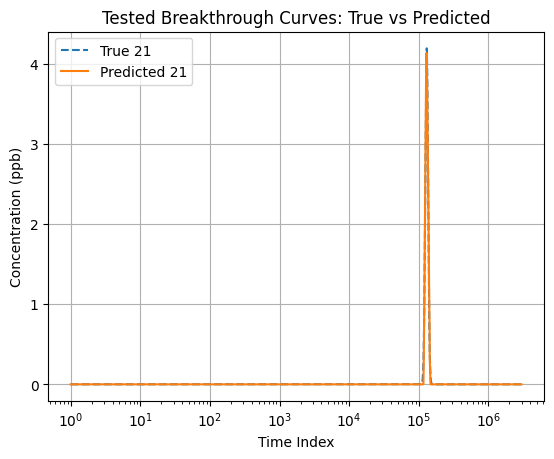

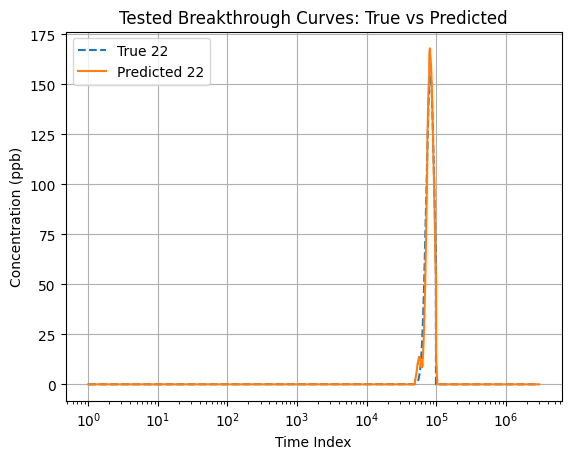

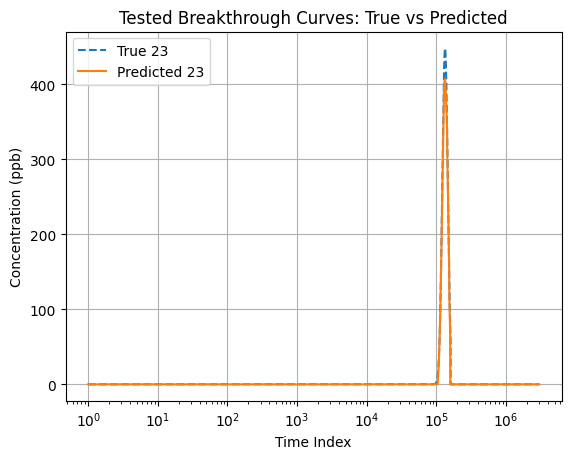

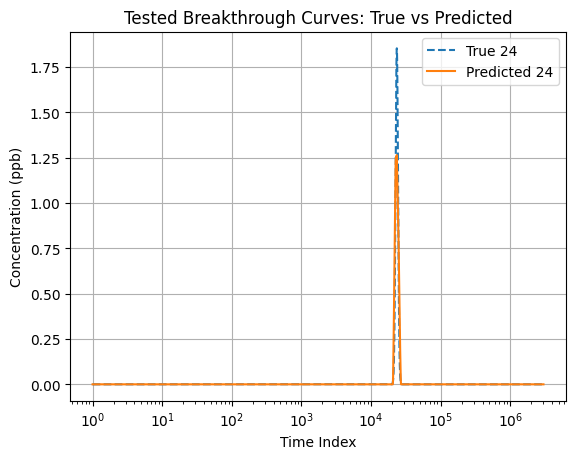

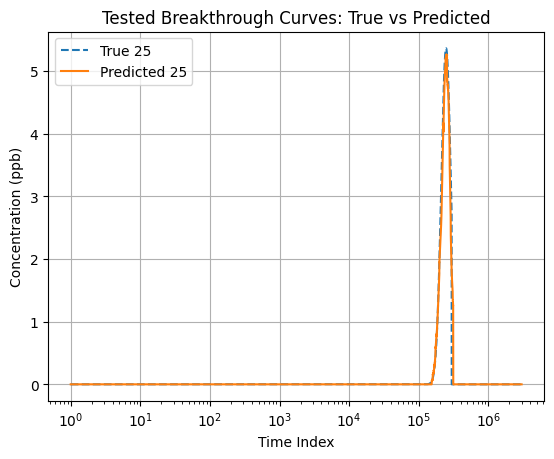

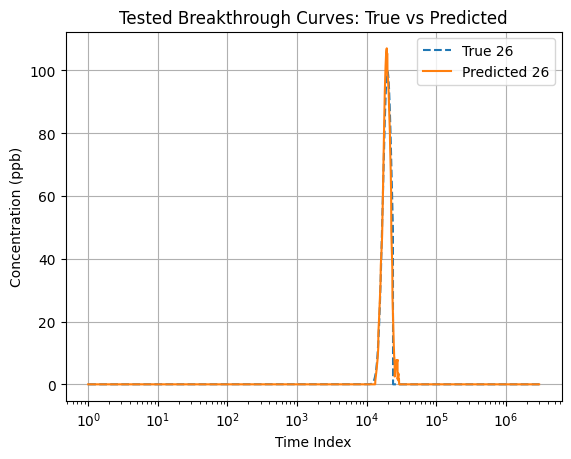

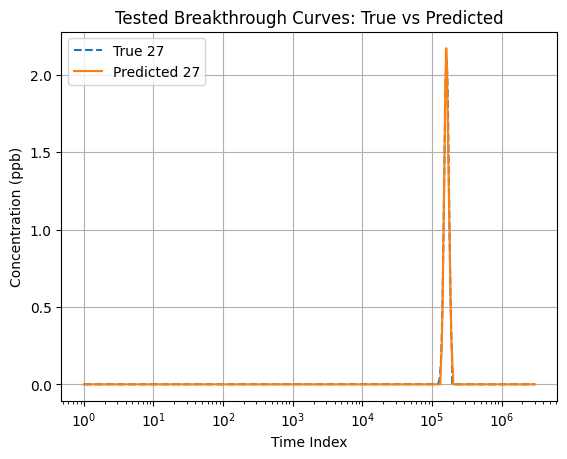

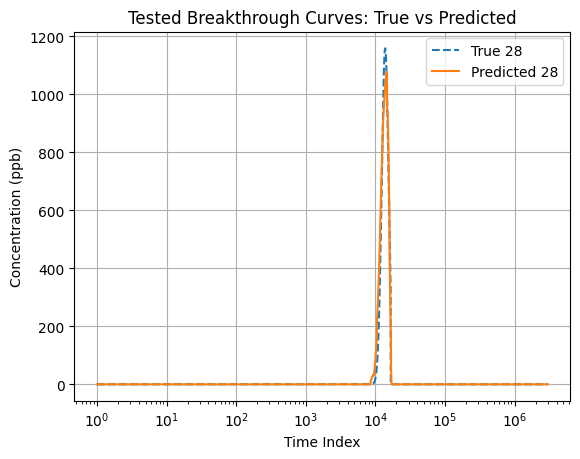

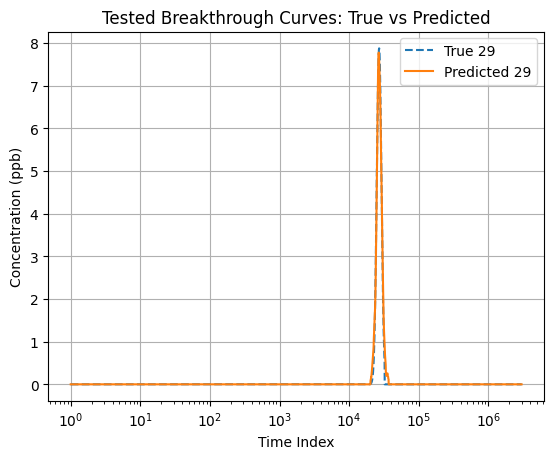

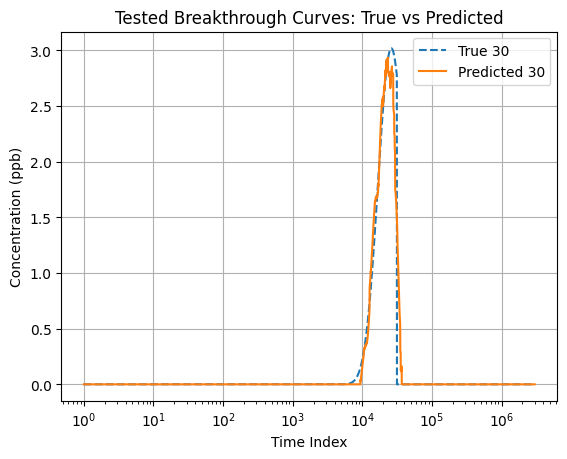

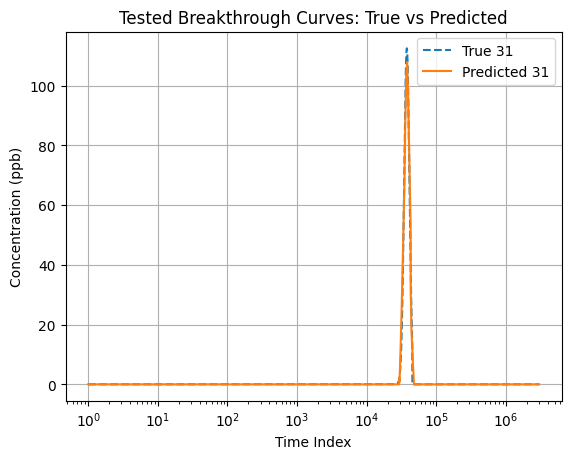

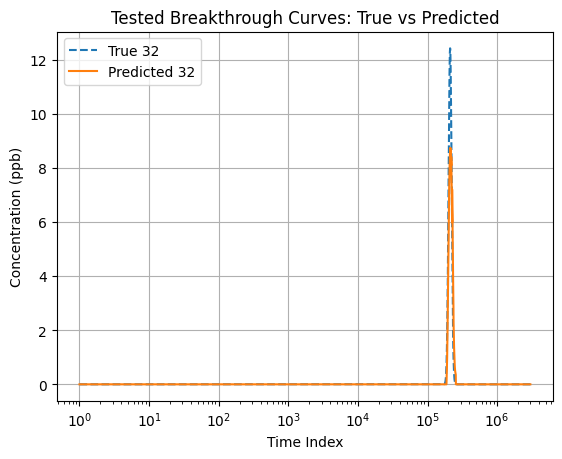

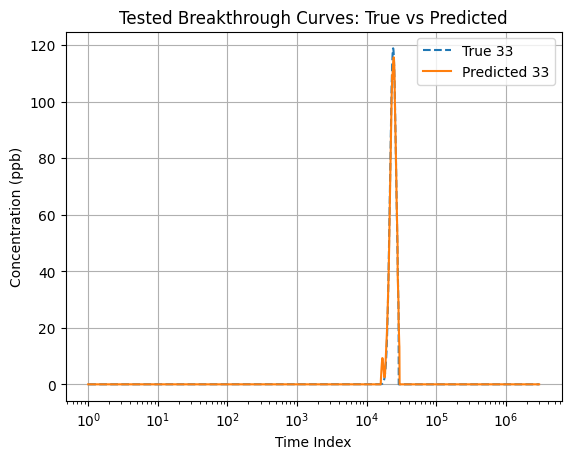

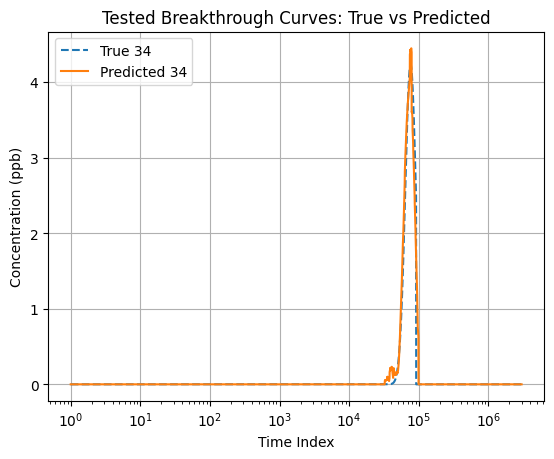

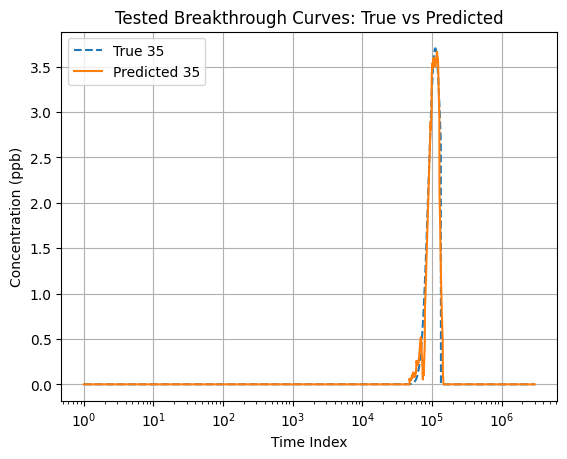

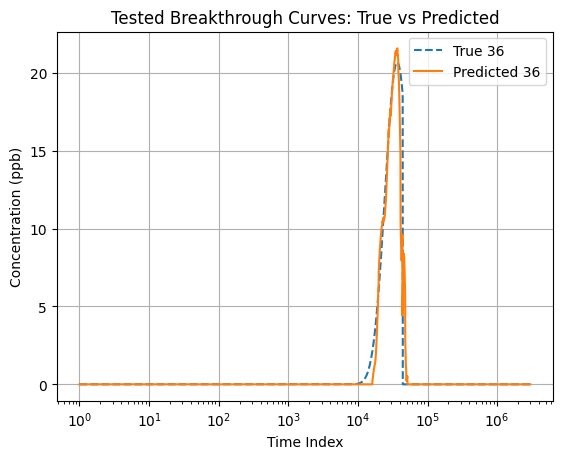

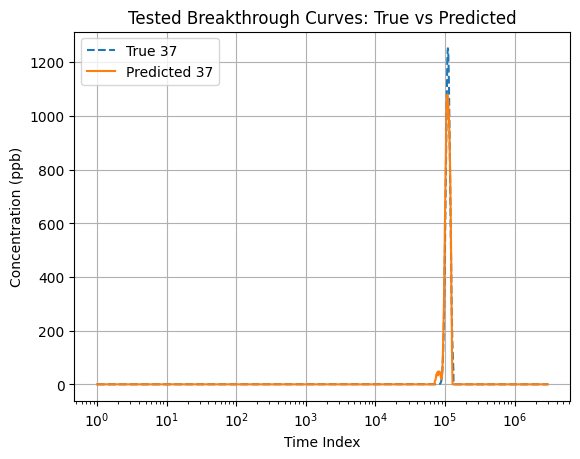

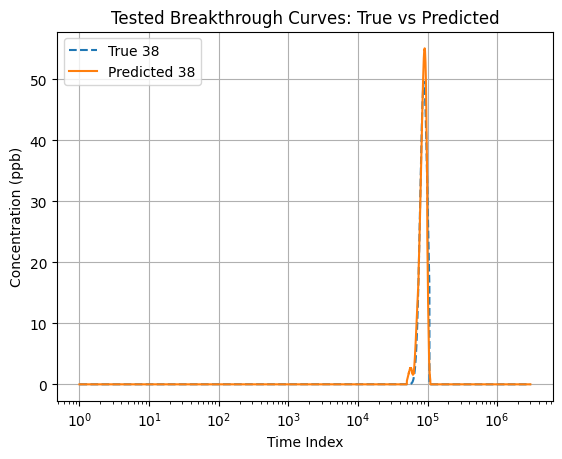

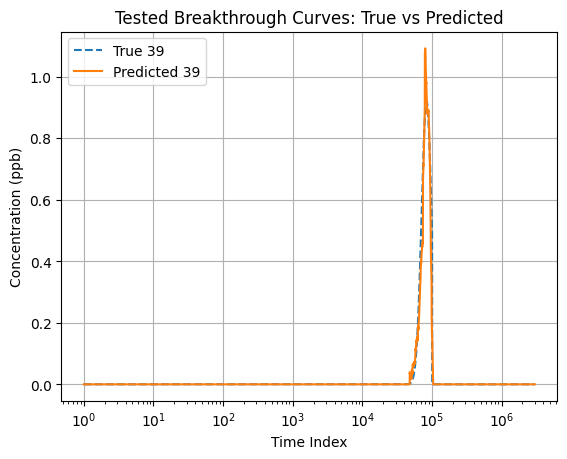

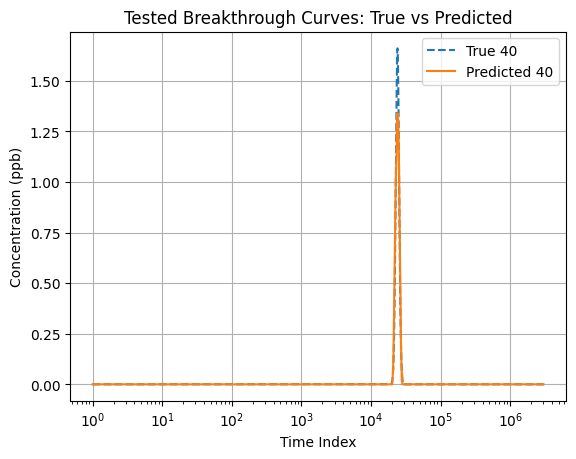

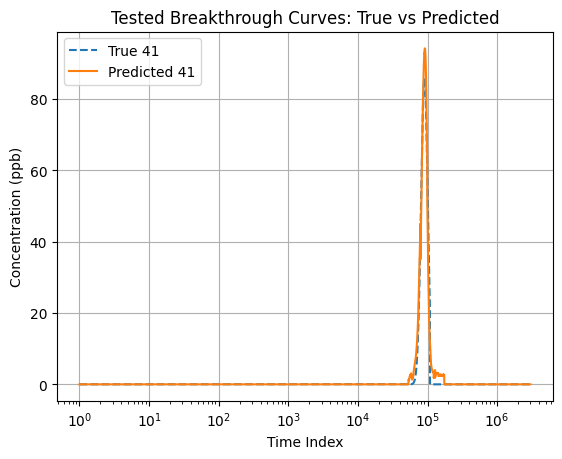

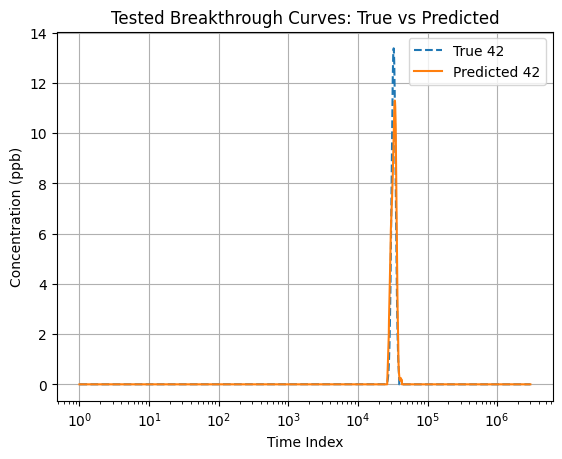

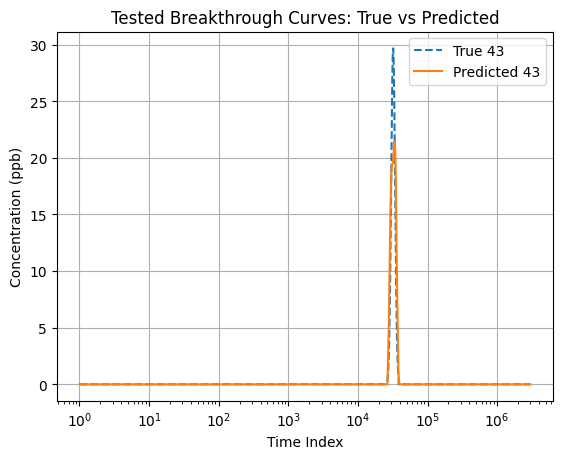

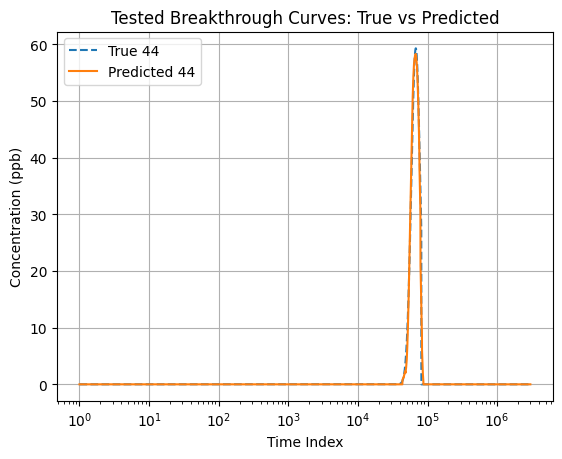

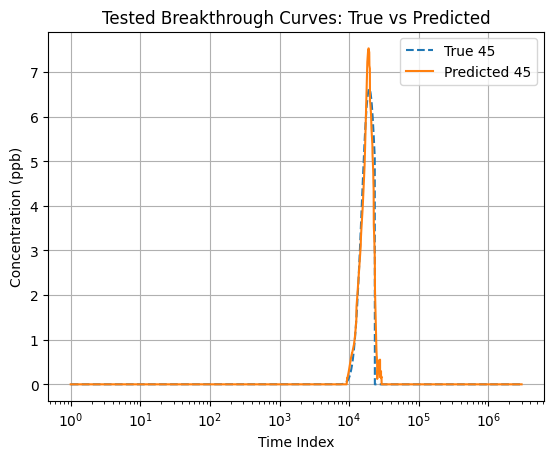

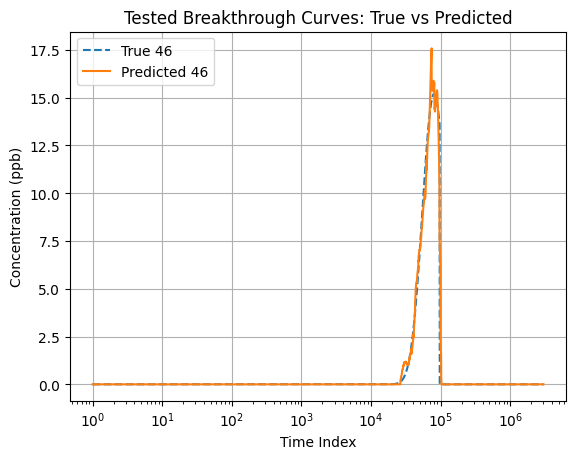

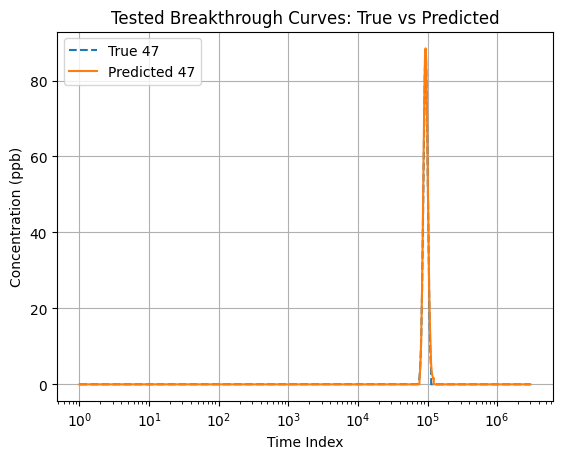

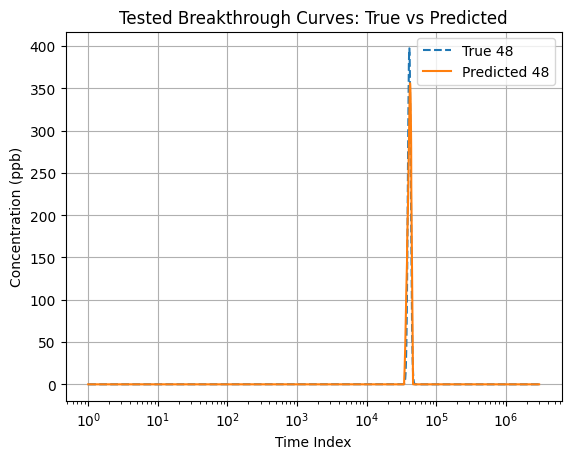

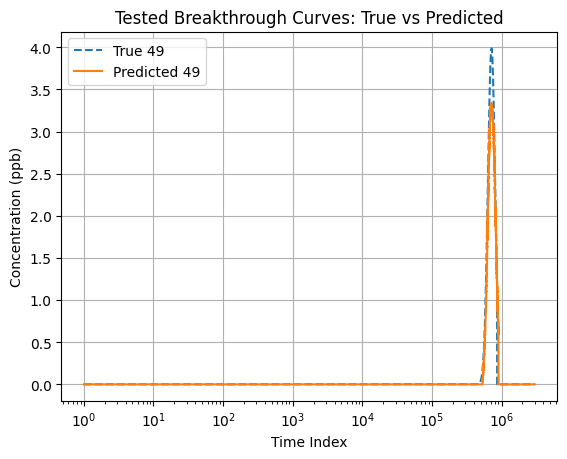

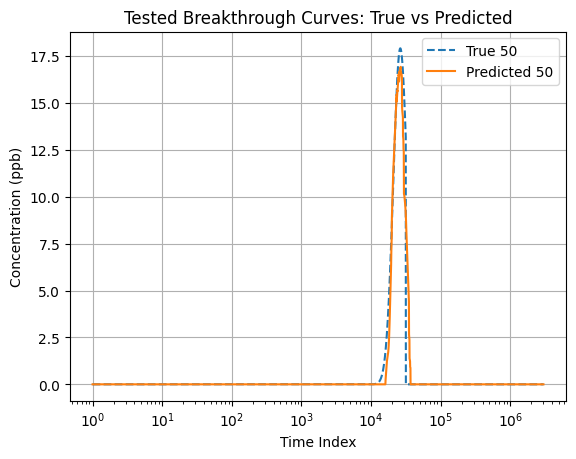

In [ ]:
num_curves_to_plot = len(actual_curves)
plt.figure(figsize=(10, 6))

for i in range(50):
    plt.semilogx(t_numpy, actual_curves[i], label=f'True {i+1}', linestyle='dashed')
    plt.semilogx(t_numpy,smooth_peak(predicted_curves[i]), label=f'Predicted {i+1}', linestyle='solid')
    plt.xlabel('Time Index')
    plt.ylabel('Concentration (ppb)')
    plt.title('Tested Breakthrough Curves: True vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

R² Score for Peak Concentration: 0.974179
R² Score (normalized independently by max): 0.975538
MAPE (%) respecto a 1:1: 9.332685
Bias Ratio: 0.9393546


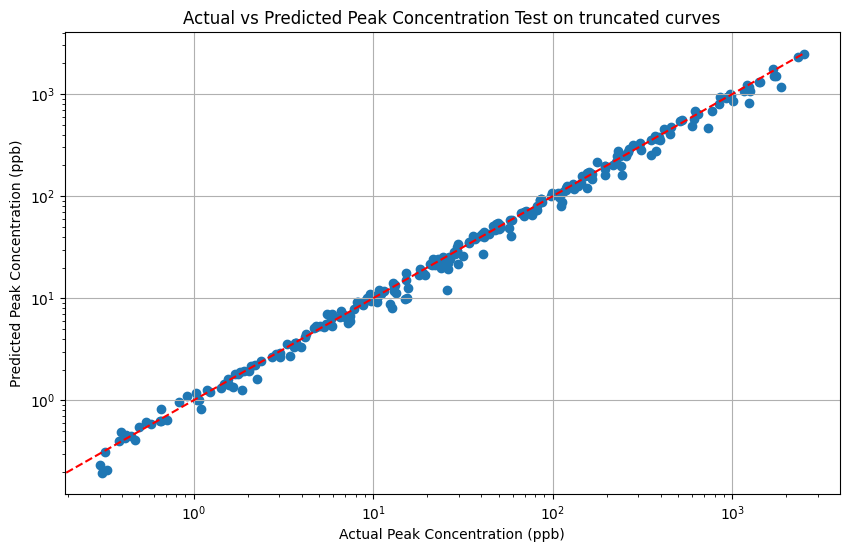

In [ ]:
# Peak concentration
actual_peak = []
predicted_peak = []

for i in range(actual_curves.shape[0]):
    actual_peak.append(np.max(actual_curves[i, :]))
    predicted_peak.append(np.max(predicted_curves[i, :]))

actual_peak = np.array(actual_peak)
predicted_peak = np.array(predicted_peak)

# R2
r2_peak = r2_score(actual_peak, predicted_peak)
print(f'R² Score for Peak Concentration: {r2_peak:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_peak - actual_peak) / actual_peak)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIS RATIO
y_true = actual_peak
y_pred = predicted_peak
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print("Bias Ratio:", bias_ratio)


x1 = np.linspace(0, np.max(actual_peak))
y1=x1
plt.figure(figsize=(10, 6))
plt.scatter(actual_peak,predicted_peak)
plt.plot(x1,y1, linestyle='--', color='r')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Predicted Peak Concentration (ppb)')
plt.xlabel('Actual Peak Concentration (ppb)')
plt.grid(True)
plt.show()

R² Score for Peak Time: 0.995476
R² Score (normalized independently by max): 0.995678
MAPE (%) respecto a 1:1: 2.6635820536525956
Bias ratio: 0.988


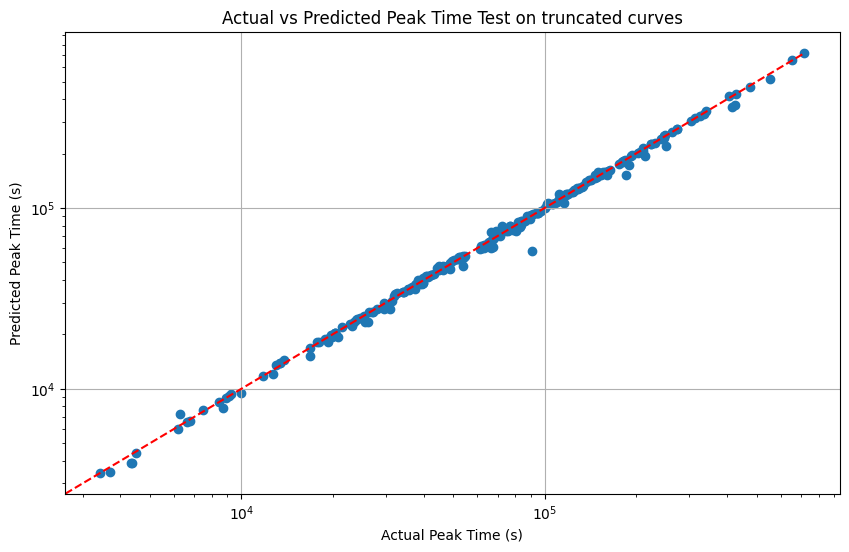

In [ ]:
# Peak time
actual_peaktime = []
predicted_peaktime = []

for i in range(actual_curves.shape[0]):
    actual_peaktime.append(t_numpy[np.argmax(actual_curves[i, :])])
    predicted_peaktime.append(t_numpy[np.argmax(predicted_curves[i, :])])

# Convert to arrays
actual_peaktime = np.array(actual_peaktime)
predicted_peaktime = np.array(predicted_peaktime)

# R2
r2_peaktime = r2_score(actual_peaktime, predicted_peaktime)
print(f'R² Score for Peak Time: {r2_peaktime:.6f}')

#MAPE
mape = np.mean(np.abs((predicted_peaktime - actual_peaktime) / actual_peaktime)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_peaktime
y_pred = predicted_peaktime
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x2 = np.linspace(0, np.max(actual_peaktime)+100)
y2=x2
plt.figure(figsize=(10, 6))
plt.scatter(actual_peaktime,predicted_peaktime)
plt.plot(x2,y2,linestyle='--', color='r')
plt.ylabel('Predicted Peak Time (s)')
plt.xlabel('Actual Peak Time (s)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

R² Score for M0: 0.997280
R² Score (normalized independently by max): 0.997310
MAPE (%) respecto a 1:1: 4.914512117193287
Bias ratio: 1.008


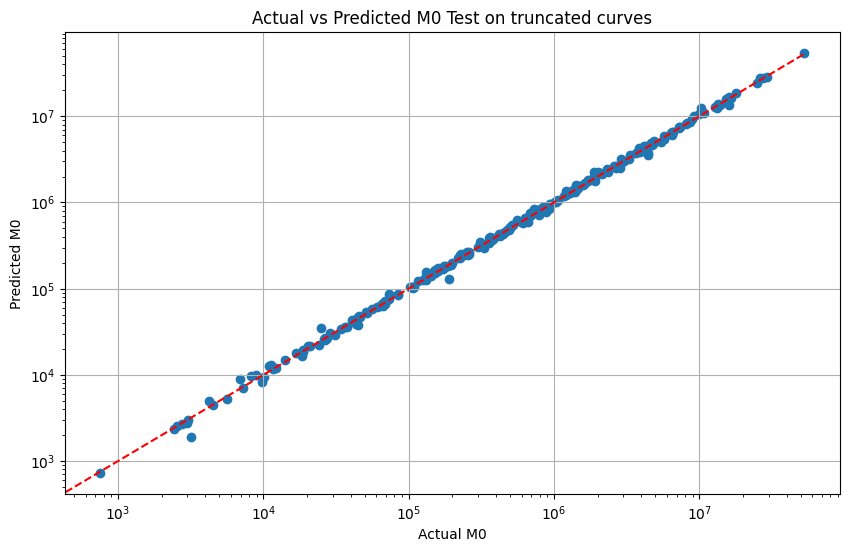

In [ ]:
actual_m0 =[]
predicted_m0 =[]

for i in range(actual_curves.shape[0]):
    actual_m0.append(np.trapezoid(actual_curves[i,:],t_reshape))
    predicted_m0.append(np.trapezoid(smooth_peak(predicted_curves[i,:]),t_reshape))

actual_m0 = np.array(actual_m0)
predicted_m0 = np.array(predicted_m0)

# R2
r2_m0 = r2_score(actual_m0, predicted_m0)
print(f'R² Score for M0: {r2_m0:.6f}')


# MAPE
mape = np.mean(np.abs((predicted_m0 - actual_m0) / actual_m0)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m0
y_pred = predicted_m0
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x3 = np.linspace(0, np.max(actual_m0)+100)
y3=x3
plt.figure(figsize=(10, 6))
plt.scatter(actual_m0,predicted_m0)
plt.plot(x3,y3,linestyle='--', color='r')
plt.ylabel('Predicted M0')
plt.xlabel('Actual M0')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

R² Score for M1: 0.989496
R² Score (normalized independently by max): 0.990619
MAPE (%) respecto a 1:1: 5.325552678791377
Bias ratio: 0.989


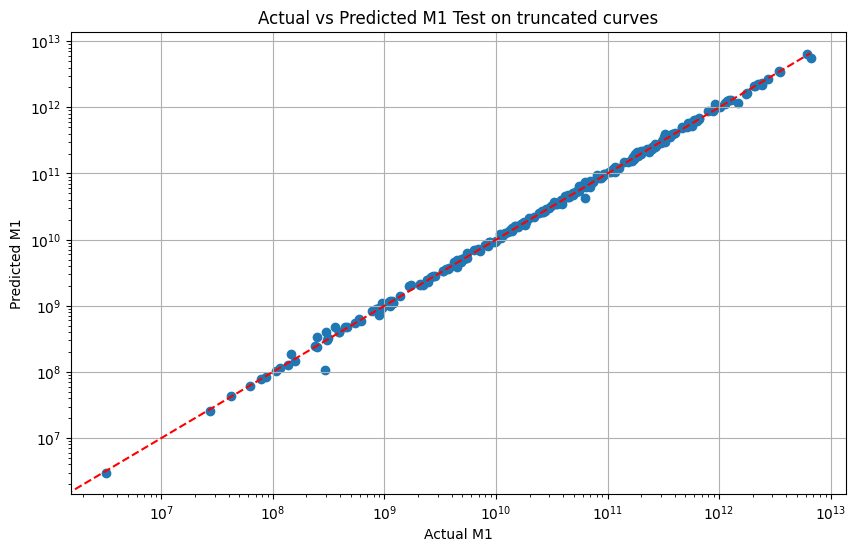

In [ ]:
actual_m1 = []
predicted_m1 = []

for i in range(actual_curves.shape[0]):
    actual_moment = actual_curves[i,:]*t_reshape
    predicted_moment = smooth_peak(predicted_curves[i,:])*t_reshape

    actual_m1.append(np.trapezoid(actual_moment,t_reshape))
    predicted_m1.append(np.trapezoid(predicted_moment,t_reshape))

actual_m1 = np.array(actual_m1)
predicted_m1 = np.array(predicted_m1)

# R2
r2_m1 = r2_score(actual_m1,predicted_m1)
print(f'R² Score for M1: {r2_m1:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m1 - actual_m1) / actual_m1)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m1
y_pred = predicted_m1
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x4 = np.linspace(0, np.max(actual_m1)+100)
y4=x4
plt.figure(figsize=(10, 6))
plt.scatter(actual_m1,predicted_m1)
plt.plot(x4,y4,linestyle='--', color='r')
plt.ylabel('Predicted M1')
plt.xlabel('Actual M1')
plt.grid(True)
plt.yscale('log')
plt.xscale('log')
plt.show()

# TEST NON-TRUNCATED DATA

In [ ]:
# TEST NON-TRUNCATED DATA

model.eval()
actual_curves_nontruncated = []
predicted_curves_nontruncated  = []

with torch.no_grad():
      outputs_test = model(x_test_nontruncated)

      actual_curves_nontruncated.extend(y_test_nontruncated.cpu().numpy())
      predicted_curves_nontruncated.extend(outputs_test.cpu().numpy())

actual_curves_nontruncated = np.array(actual_curves_nontruncated)
predicted_curves_nontruncated = np.array(predicted_curves_nontruncated)
predicted_curves_nontruncated[predicted_curves_nontruncated < 0] = 0

In [ ]:
max_lag = 100
use_normalize = 'zscore'

cc_results = []
for i in range(actual_curves_nontruncated.shape[0]):
    a = actual_curves_nontruncated[i]
    b = smooth_peak(predicted_curves_nontruncated[i])
    res = best_lag_correlation(a, b, max_lag=max_lag, normalize=use_normalize)
    cc_results.append(res)

cc_mean_corr = np.mean([r['corr'] for r in cc_results])
print(f"[Cross-Correlation] Correlación media (al mejor lag): {cc_mean_corr:.4f}")

all_lags = [res['lag'] for res in cc_results]
all_corrs = [res['corr'] for res in cc_results]

all_lags = np.array(all_lags)
all_corrs = np.array(all_corrs)

print("Lags:", all_lags[:5])
print("Correlaciones:", all_corrs[:5])

[0.981177031993866, 0.9866626858711243, 0.9433648586273193, 0.9953279495239258, 0.934302568435669, 0.7378861308097839, 0.9170477986335754, 0.9230881929397583, 0.9868557453155518, 0.8894448280334473, 0.9691631197929382, 0.969784140586853, 0.9872050285339355, 0.897217869758606, 0.9866544604301453, 0.9991466403007507, 0.5354800820350647, 0.9778859615325928, 0.9809930920600891, 0.9571779370307922, 0.9276697039604187, 0.9732260704040527, 0.8410414457321167, 0.7614712715148926, 0.9873422980308533, 0.966951847076416, 0.9510729908943176, 0.9283114671707153, 0.9911307096481323, 0.9911900758743286, 0.9710898399353027, 0.9766535758972168, 0.9917412400245667, 0.9832810163497925, 0.9978509545326233, 0.7953208088874817, 0.9606819748878479, 0.9678369760513306, 0.8647341132164001, 0.946205198764801, 0.8622252941131592, 0.9408590197563171, 0.98170405626297, 0.9899064302444458, 0.8135696649551392, 0.8874064087867737, 0.960830807685852, 0.9543123841285706, 0.6725755929946899, 0.9109998941421509, 0.925829

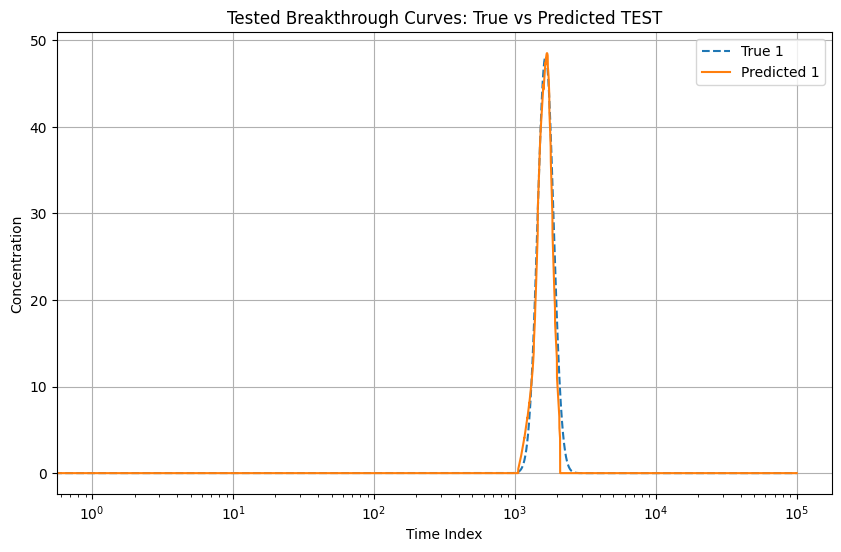

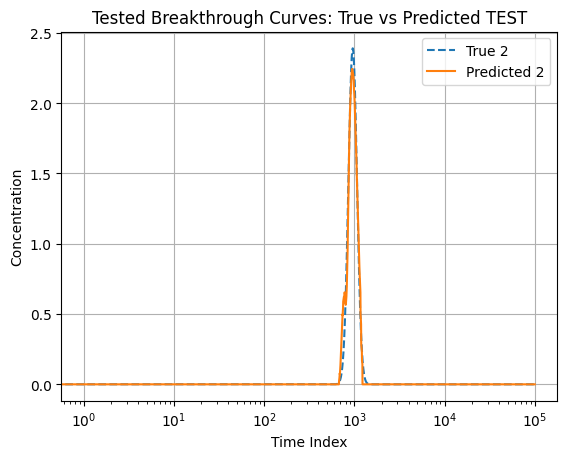

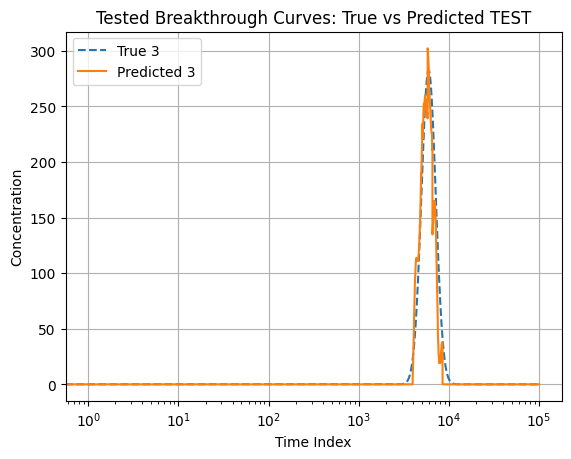

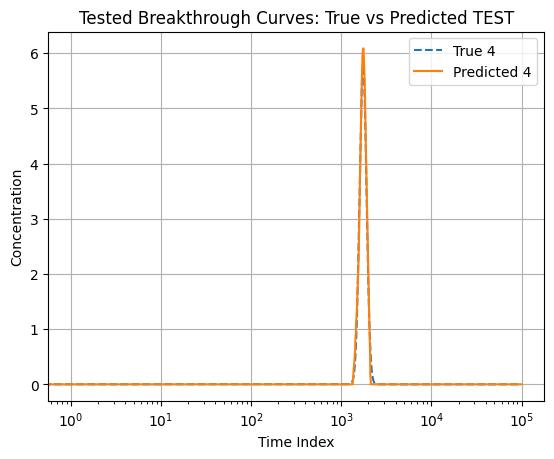

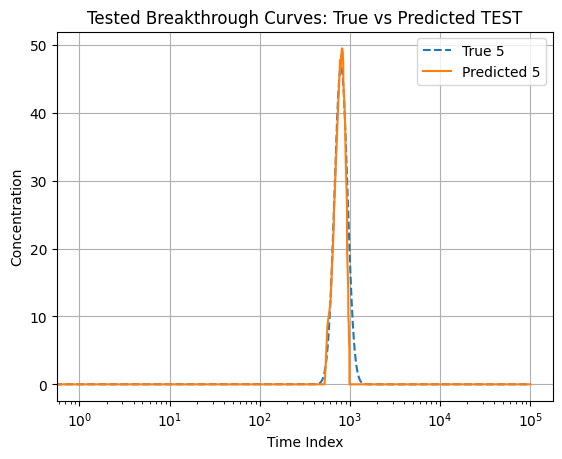

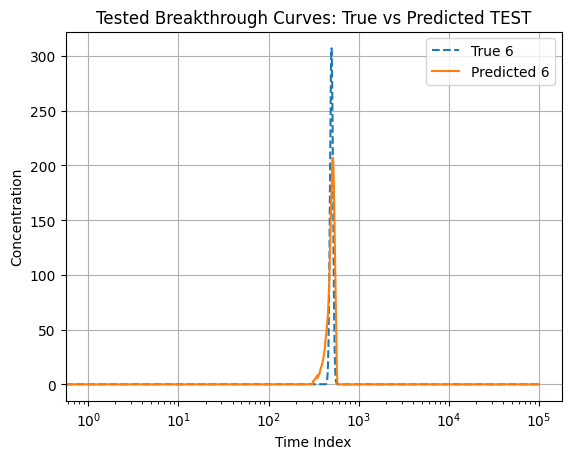

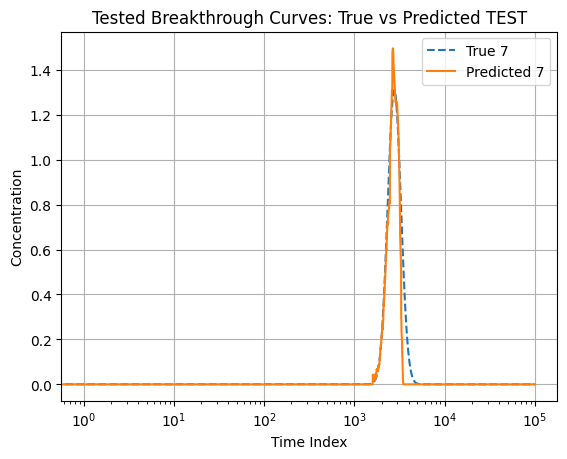

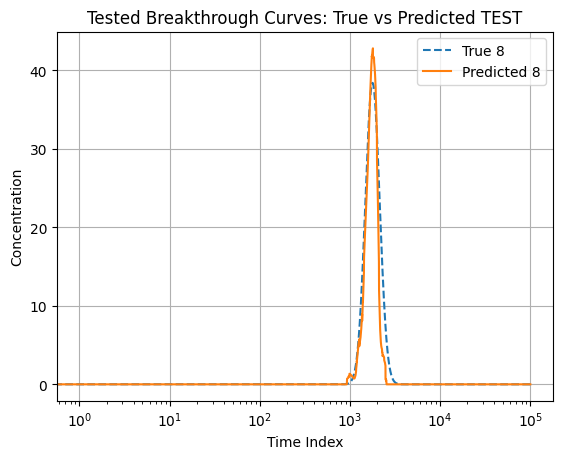

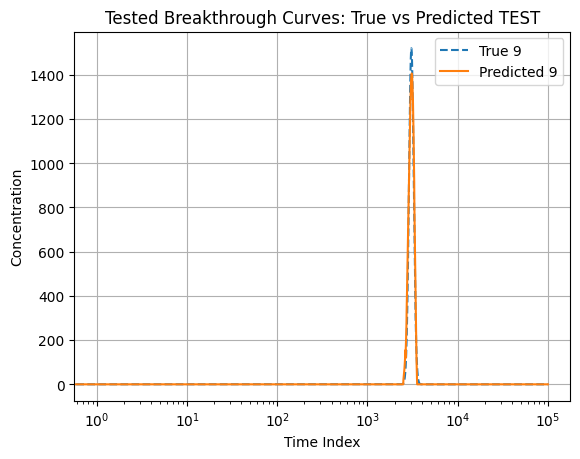

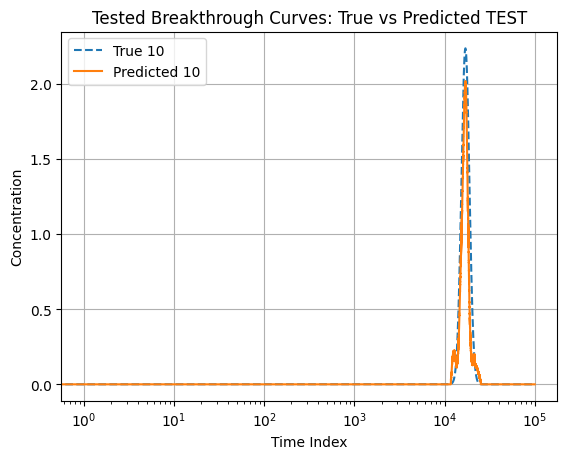

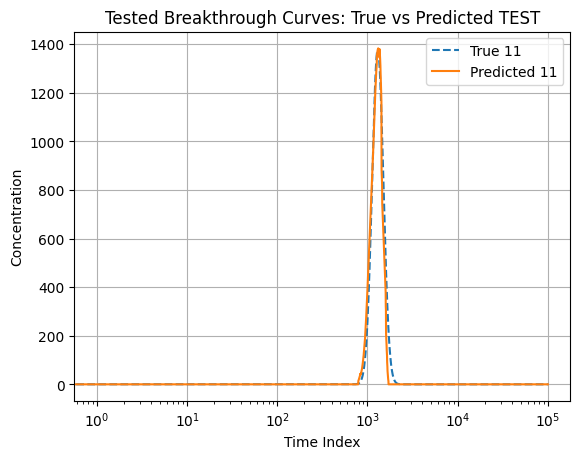

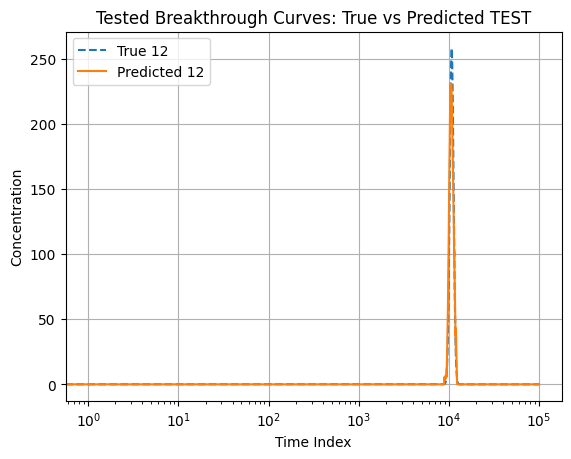

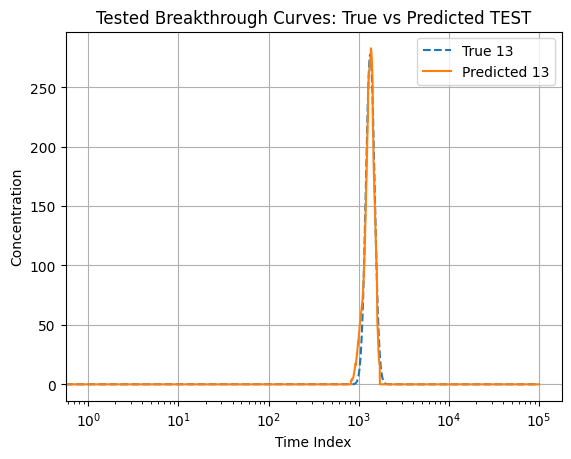

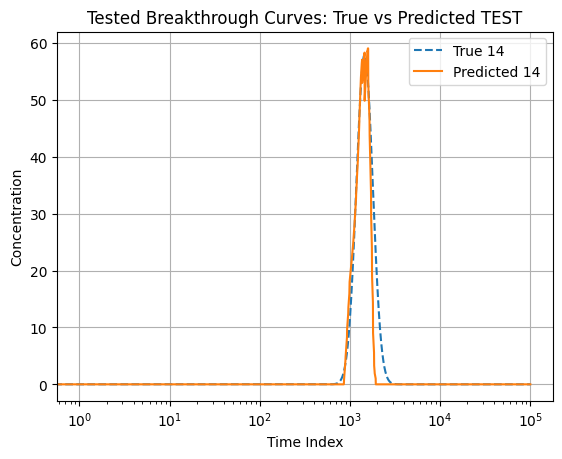

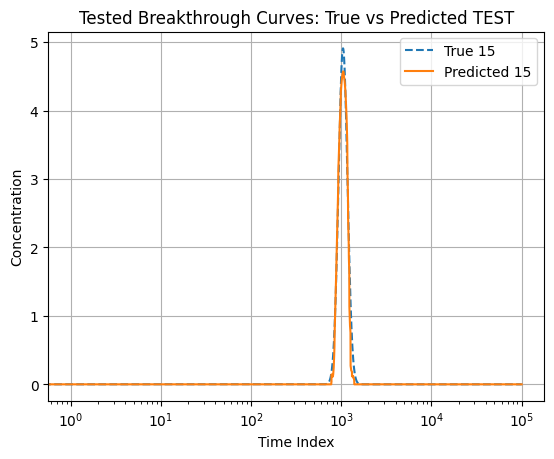

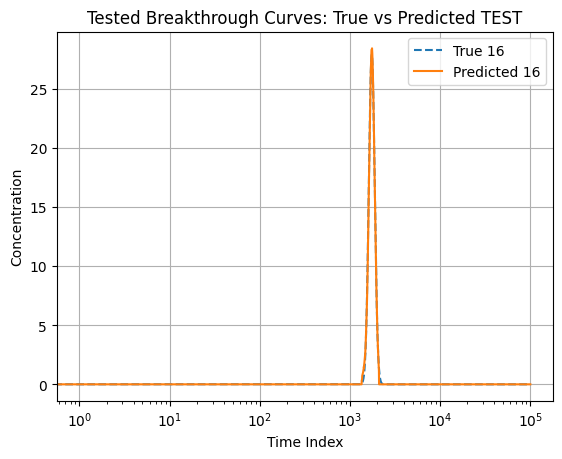

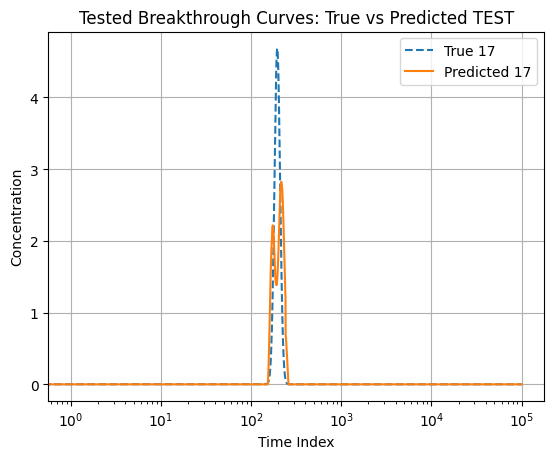

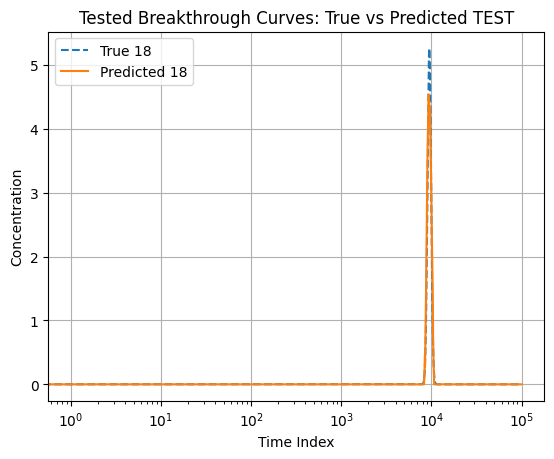

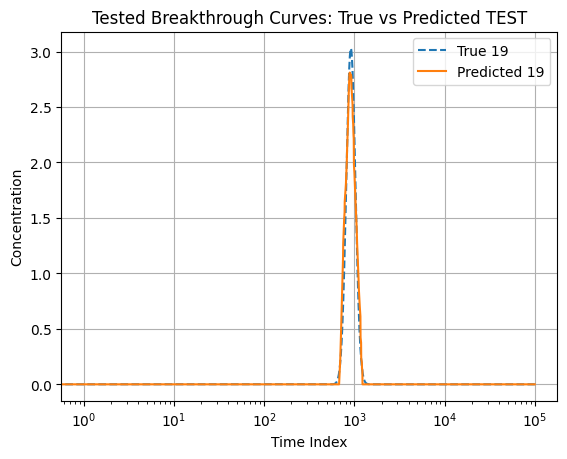

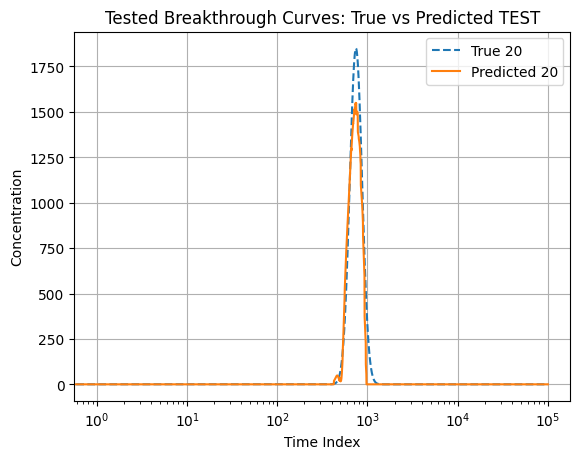

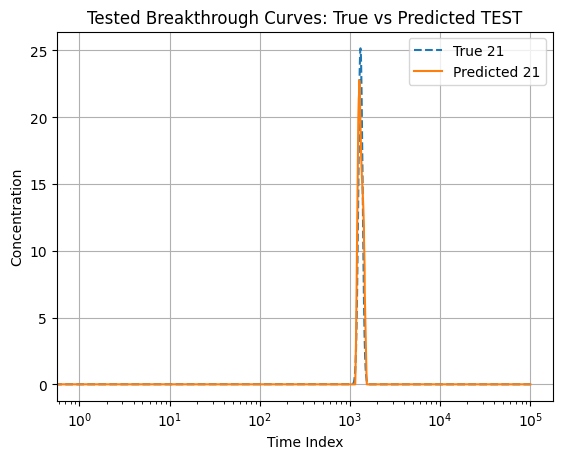

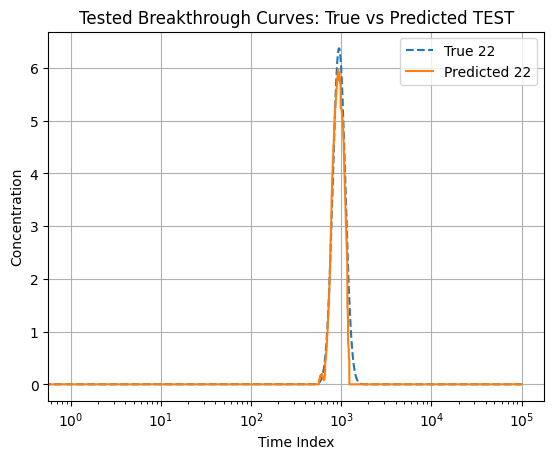

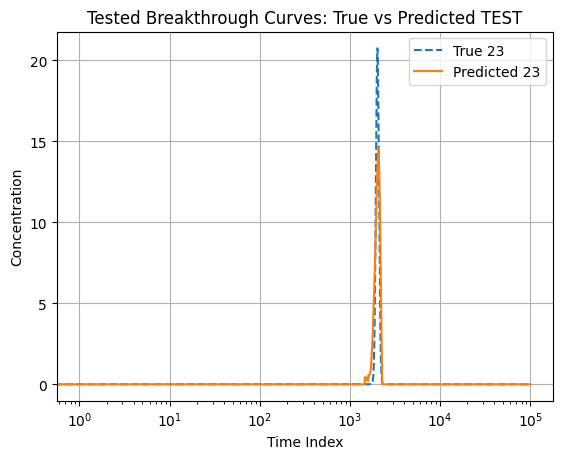

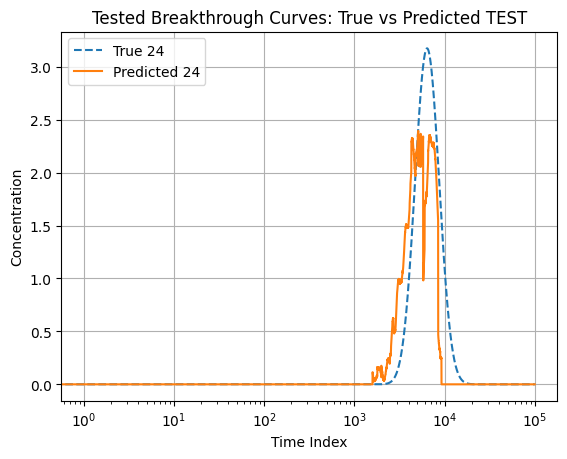

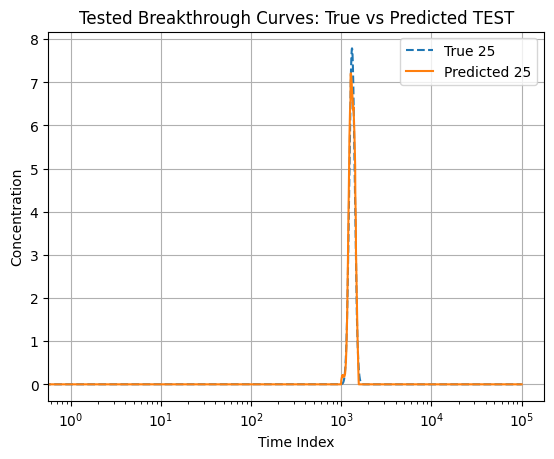

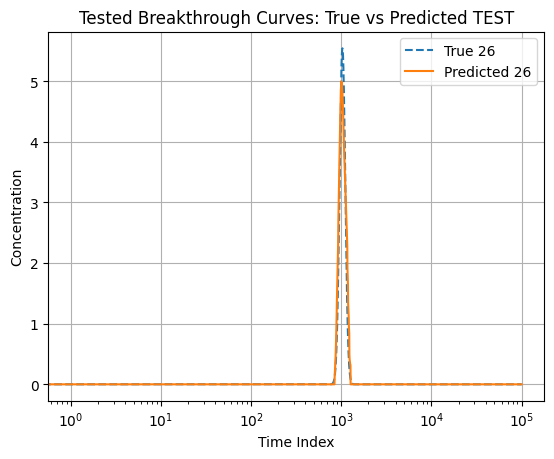

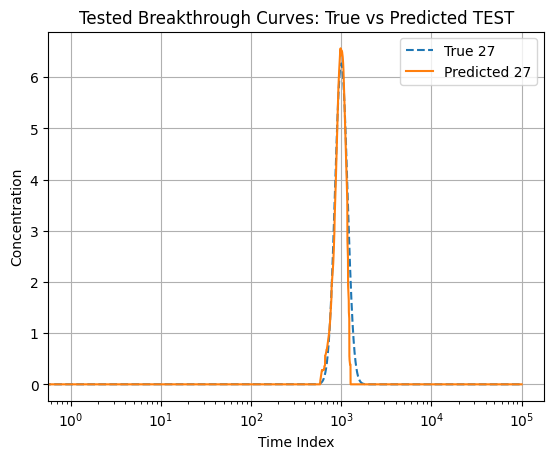

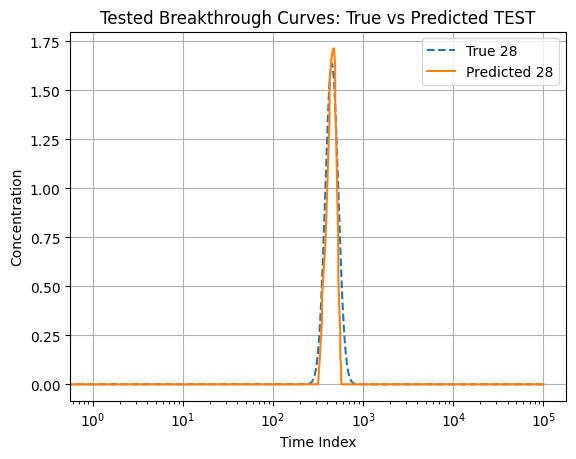

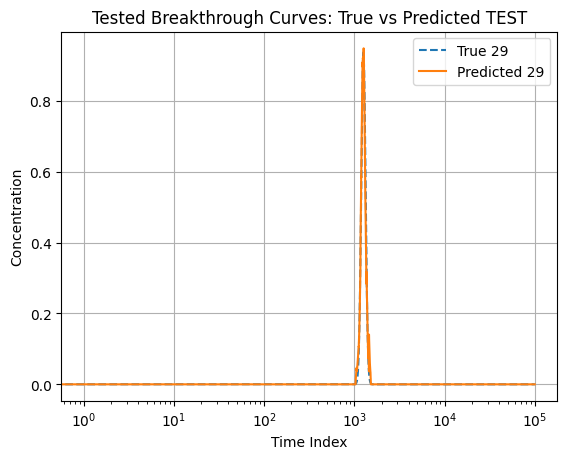

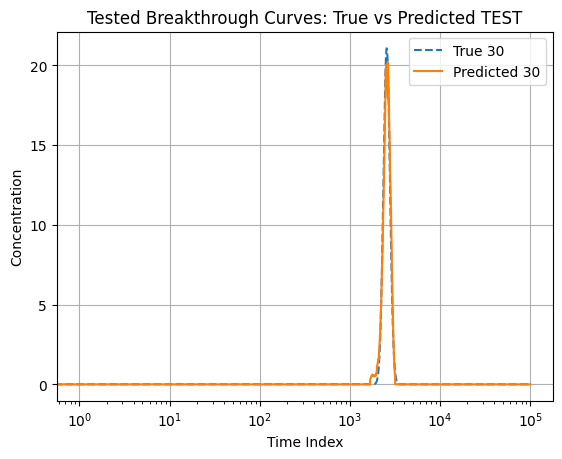

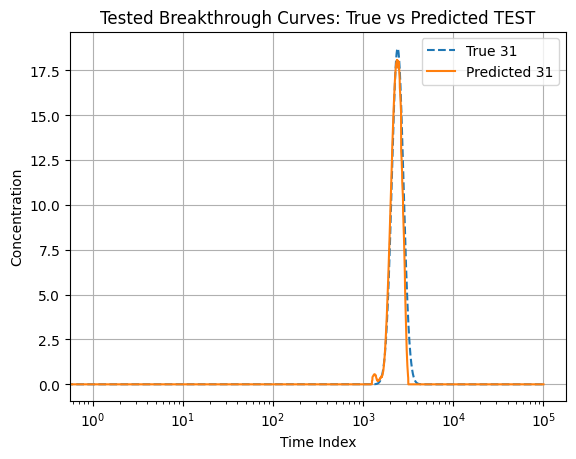

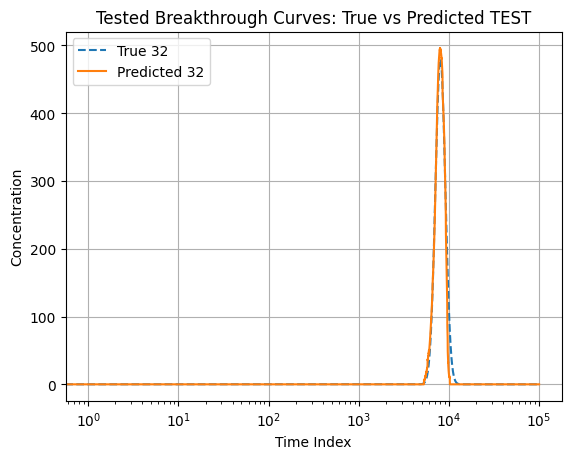

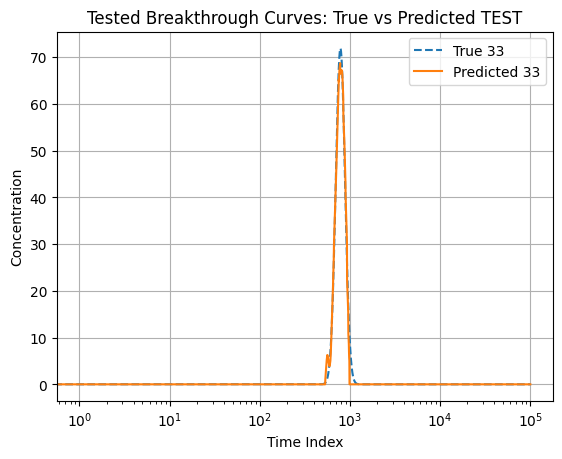

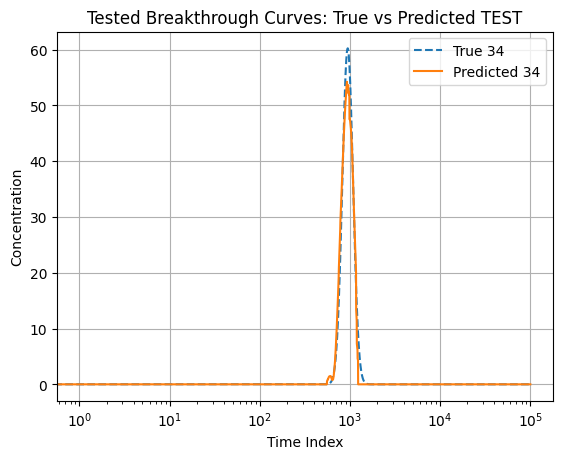

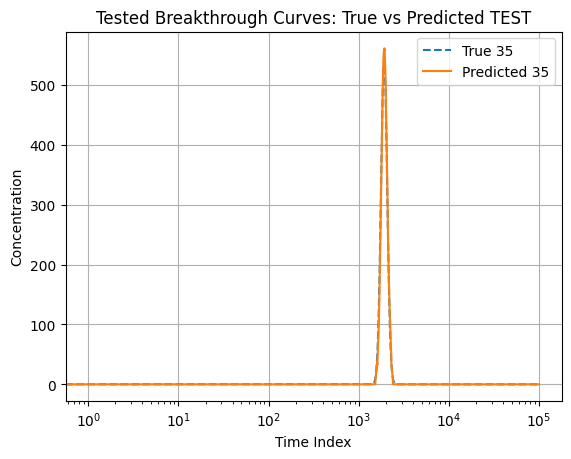

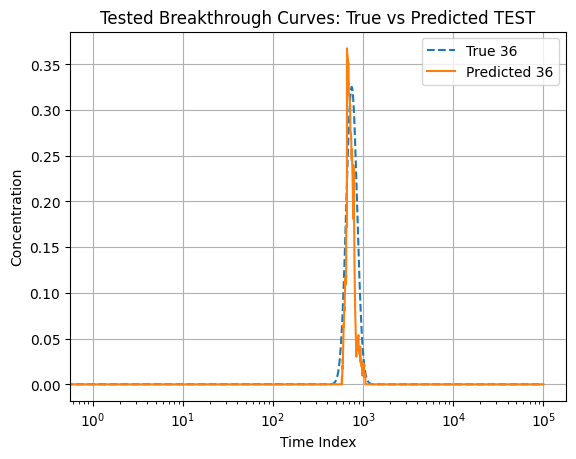

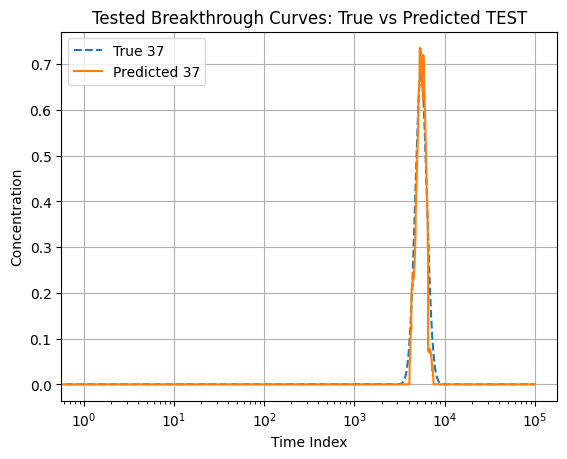

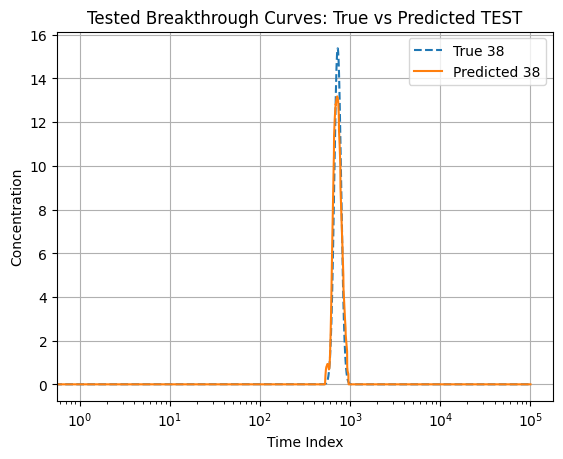

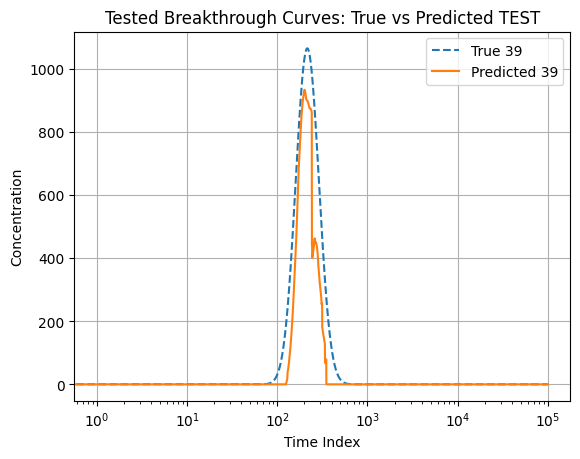

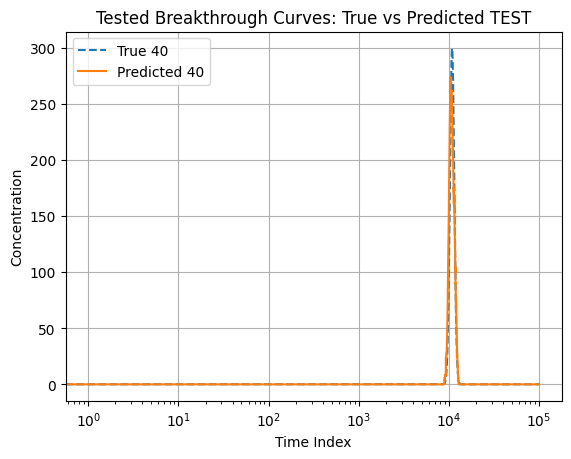

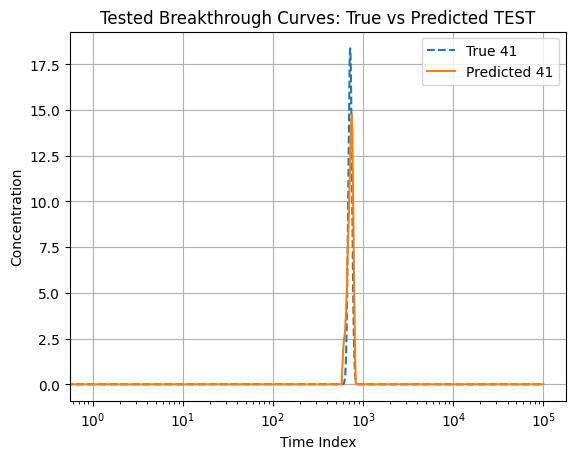

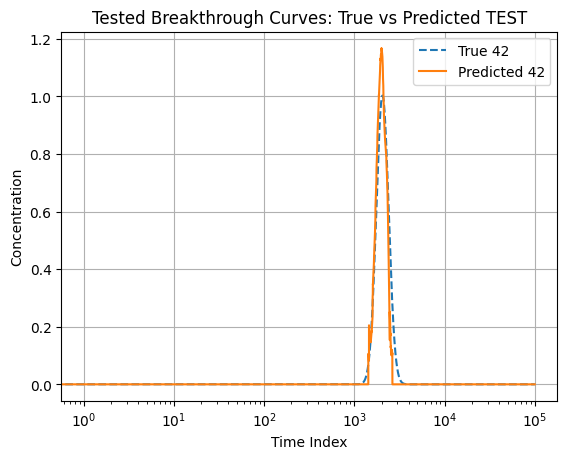

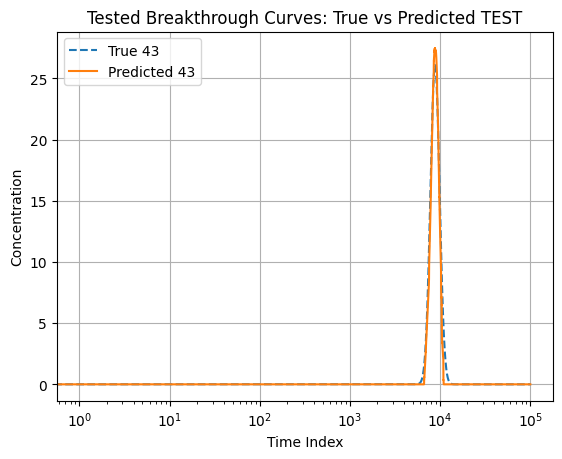

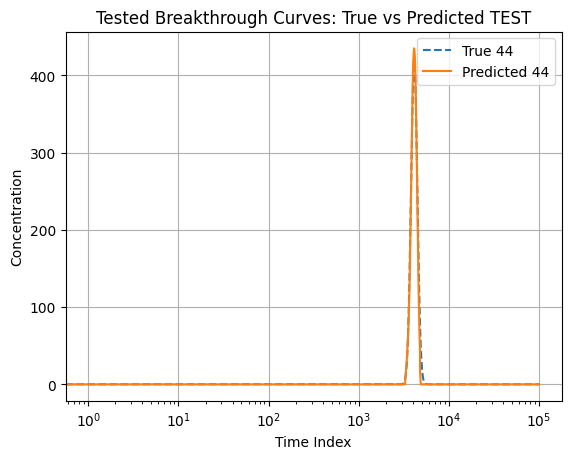

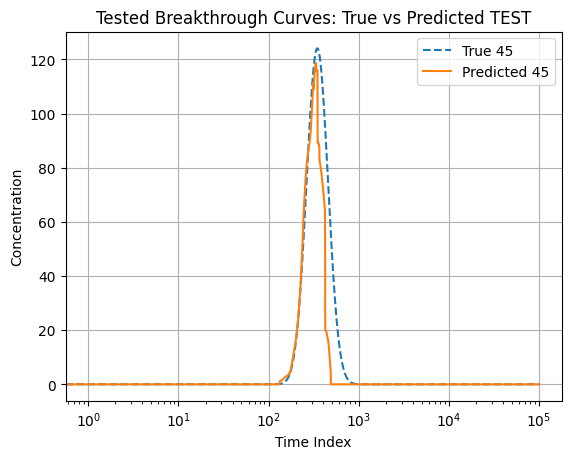

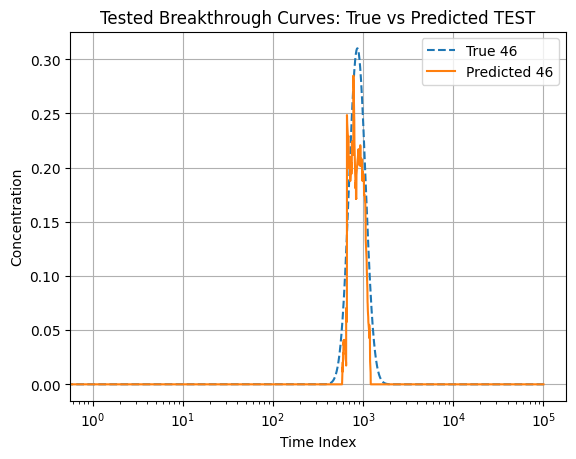

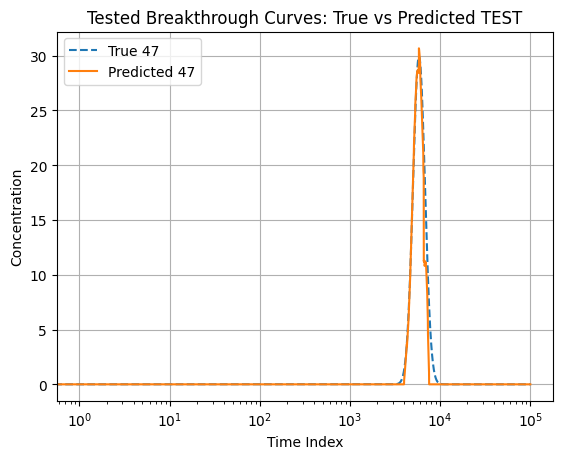

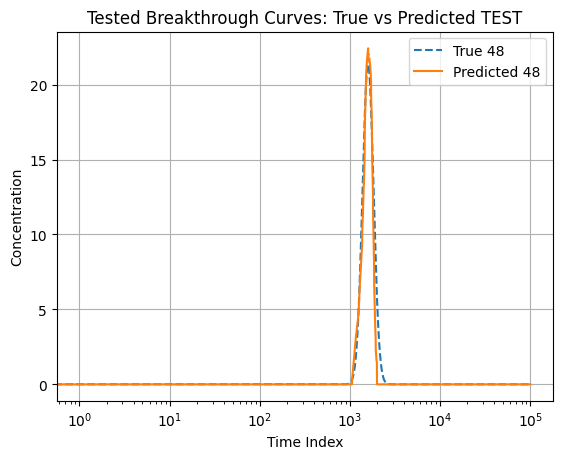

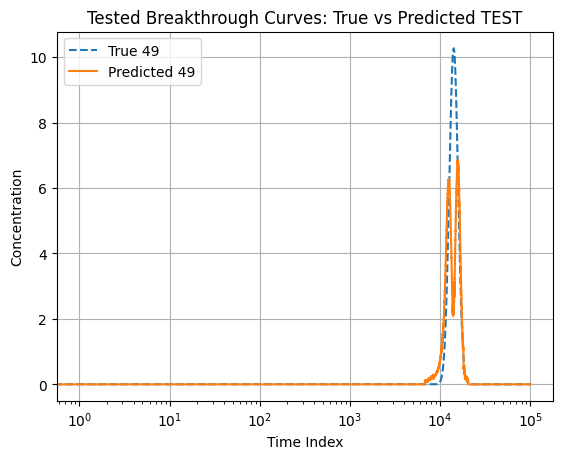

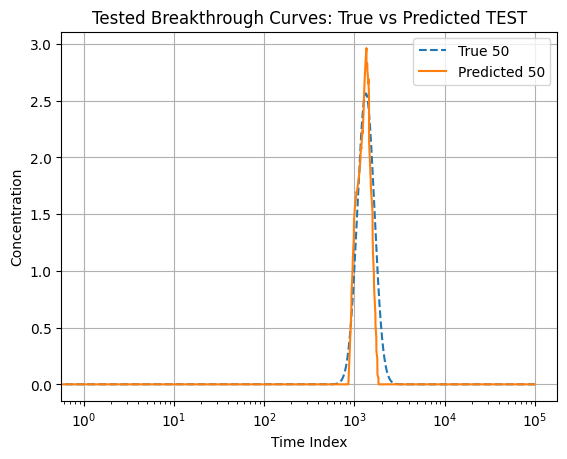

In [ ]:
num_curves_to_plot = len(actual_curves_nontruncated)
plt.figure(figsize=(10, 6))

for i in range(50):
    plt.semilogx(actual_curves_nontruncated[i], label=f'True {i+1}', linestyle='dashed')
    plt.semilogx(smooth_peak(predicted_curves_nontruncated[i]), label=f'Predicted {i+1}', linestyle='solid')
    plt.xlabel('Time Index')
    plt.ylabel('Concentration')
    plt.title('Tested Breakthrough Curves: True vs Predicted TEST')
    plt.legend()
    plt.grid(True)
    plt.show()

R² Score for Peak Concentration: 0.958101
R² Score (normalized independently by max): 0.958474
MAPE (%) respecto a 1:1: 9.502712
Bias Ratio: 0.955483


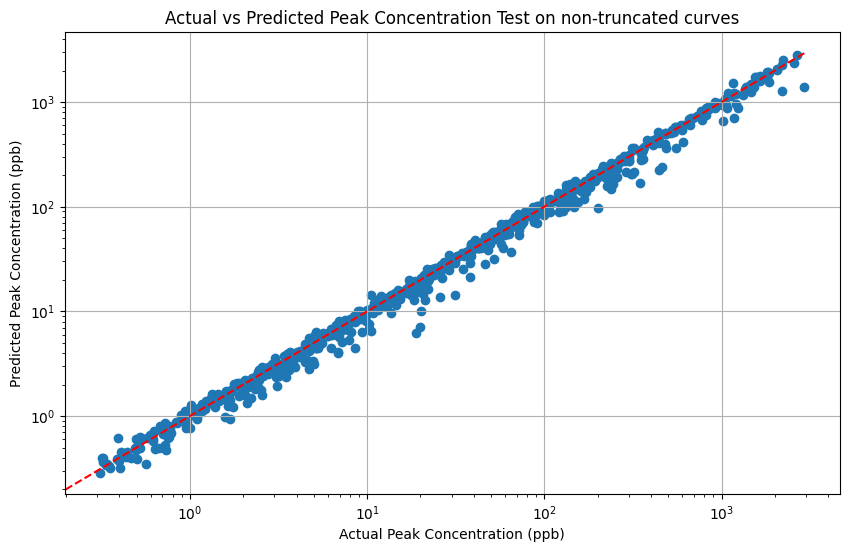

In [ ]:
# Peak concentration
actual_peak = []
predicted_peak = []

for i in range(actual_curves_nontruncated.shape[0]):
    actual_peak.append(np.max(actual_curves_nontruncated[i, :]))
    predicted_peak.append(np.max(predicted_curves_nontruncated[i, :]))

actual_peak = np.array(actual_peak)
predicted_peak = np.array(predicted_peak)

# R2
r2_peak = r2_score(actual_peak, predicted_peak)
print(f'R² Score for Peak Concentration: {r2_peak:.6f}')


# MAPE
mape = np.mean(np.abs((predicted_peak - actual_peak) / actual_peak)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIS RATIO
y_true = actual_peak
y_pred = predicted_peak
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print("Bias Ratio:", bias_ratio)


x1 = np.linspace(0, np.max(actual_peak))
y1=x1
plt.figure(figsize=(10, 6))
plt.scatter(actual_peak,predicted_peak)
plt.plot(x1,y1, linestyle='--', color='r')
plt.ylabel('Predicted Peak Concentration (ppb)')
plt.xlabel('Actual Peak Concentration (ppb)')
plt.grid(True)

plt.yscale('log')
plt.xscale('log')
plt.show()

R² Score for Peak Time: 0.993198
R² Score (normalized independently by max): 0.965765
MAPE (%) respecto a 1:1: 2.3226114425312074
Absolute errors: [1.17001131e+03 4.50004350e+02 4.14004002e+03 3.00002900e+02
 7.20006960e+02 4.80004640e+02 2.85002755e+03 5.70005510e+02
 8.10007830e+02 8.40008120e+02 4.80004640e+02 4.41004263e+03
 6.30006090e+02 4.02003886e+03 1.80001740e+02 3.30003190e+02
 6.30006090e+02 4.47004321e+03 7.20006960e+02 1.50001450e+02
 1.20001160e+03 5.70005510e+02 1.56001508e+03 3.88803758e+04
 1.14001102e+03 6.60006380e+02 4.80004640e+02 6.60006380e+02
 2.10002030e+02 2.43002349e+03 9.60009280e+02 2.34002262e+03
 1.20001160e+02 5.10004930e+02 4.80004640e+02 2.55002465e+03
 2.91002813e+03 2.70002610e+02 4.20004060e+02 1.35001305e+04
 9.30008990e+02 1.38001334e+03 3.90003770e+02 3.30003190e+02
 3.00002900e+02 2.49002407e+03 3.30003190e+02 1.50001450e+02
 4.66804512e+04 6.30006090e+02 3.90003770e+02 1.20001160e+02
 1.20001160e+02 7.50007250e+02 3.90003770e+02 5.10004930e+02

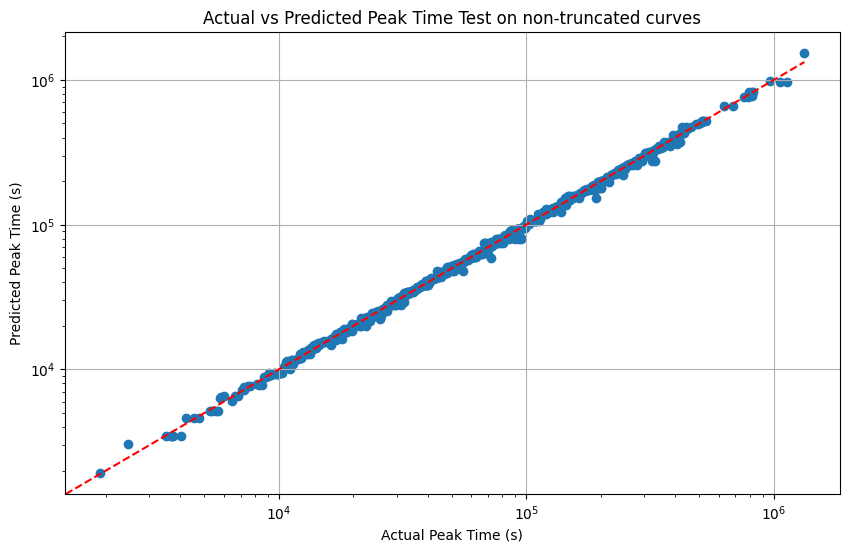

In [ ]:
# Peak time
actual_peaktime = []
predicted_peaktime = []

for i in range(actual_curves_nontruncated.shape[0]):
    actual_peaktime.append(t_numpy[np.argmax(actual_curves_nontruncated[i, :])])
    predicted_peaktime.append(t_numpy[np.argmax(predicted_curves_nontruncated[i, :])])

# Convert to arrays
actual_peaktime = np.array(actual_peaktime)
predicted_peaktime = np.array(predicted_peaktime)

# R2
r2_peaktime = r2_score(actual_peaktime, predicted_peaktime)
print(f'R² Score for Peak Time: {r2_peaktime:.6f}')

#MAPE
mape = np.mean(np.abs((predicted_peaktime - actual_peaktime) / actual_peaktime)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_peaktime
y_pred = predicted_peaktime
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x2 = np.linspace(0, np.max(actual_peaktime)+100)
y2=x2
plt.figure(figsize=(10, 6))
plt.scatter(actual_peaktime,predicted_peaktime)
plt.plot(x2,y2,linestyle='--', color='r')
plt.ylabel('Predicted Peak Time (s)')
plt.xlabel('Actual Peak Time (s)')
plt.grid(True)

plt.yscale('log')
plt.xscale('log')
plt.show()

R² Score for M0: 0.931388
R² Score (normalized independently by max): 0.926018
MAPE (%) respecto a 1:1: 13.586772959217342
Bias ratio: 0.867


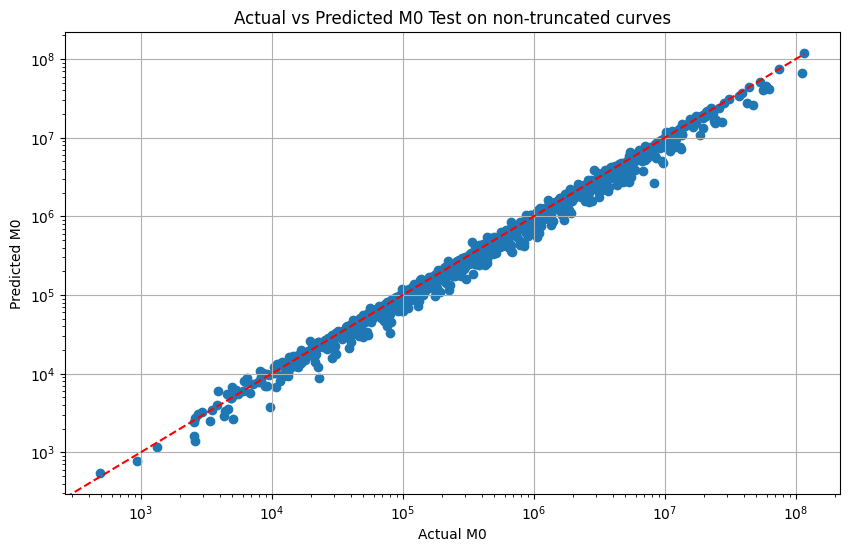

In [ ]:
actual_m0 =[]
predicted_m0 =[]

for i in range(actual_curves_nontruncated.shape[0]):
    actual_m0.append(np.trapezoid(actual_curves_nontruncated[i,:],t_reshape))
    predicted_m0.append(np.trapezoid(smooth_peak(predicted_curves_nontruncated[i,:]),t_reshape))

actual_m0 = np.array(actual_m0)
predicted_m0 = np.array(predicted_m0)

# R2
r2_m0 = r2_score(actual_m0, predicted_m0)
print(f'R² Score for M0: {r2_m0:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m0 - actual_m0) / actual_m0)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m0
y_pred = predicted_m0
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x3 = np.linspace(0, np.max(actual_m0)+100)
y3=x3
plt.figure(figsize=(10, 6))
plt.scatter(actual_m0,predicted_m0)
plt.plot(x3,y3,linestyle='--', color='r')
plt.ylabel('Predicted M0')
plt.xlabel('Actual M0')
plt.grid(True)

plt.yscale('log')
plt.xscale('log')
plt.show()

R² Score for M1: 0.871993
R² Score (normalized independently by max): 0.900415
MAPE (%) respecto a 1:1: 16.25690267658296
Bias ratio: 0.816


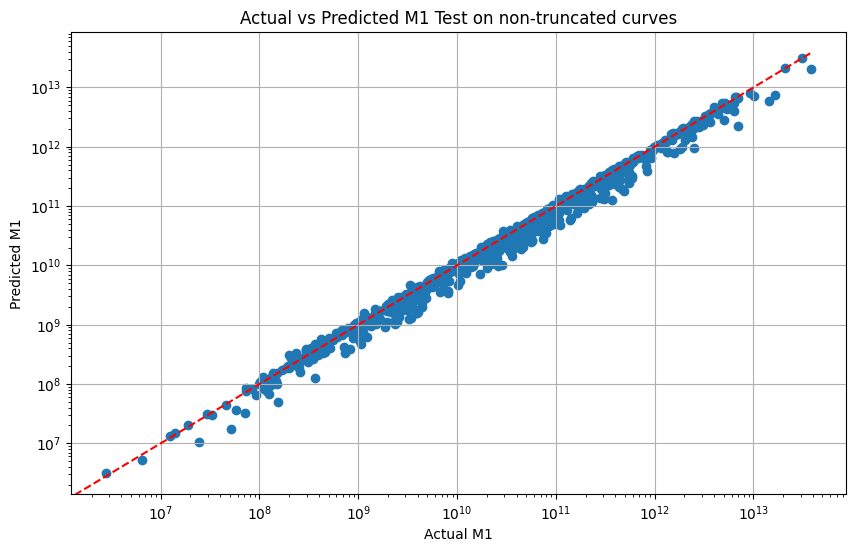

In [ ]:
actual_m1 = []
predicted_m1 = []

for i in range(actual_curves_nontruncated.shape[0]):
    actual_moment = actual_curves_nontruncated[i,:]*t_reshape
    predicted_moment = smooth_peak(predicted_curves_nontruncated[i,:])*t_reshape

    actual_m1.append(np.trapezoid(actual_moment,t_reshape))
    predicted_m1.append(np.trapezoid(predicted_moment,t_reshape))

actual_m1 = np.array(actual_m1)
predicted_m1 = np.array(predicted_m1)

# R2
r2_m1 = r2_score(actual_m1,predicted_m1)
print(f'R² Score for M1: {r2_m1:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m1 - actual_m1) / actual_m1)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m1
y_pred = predicted_m1
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x4 = np.linspace(0, np.max(actual_m1)+100)
y4=x4
plt.figure(figsize=(10, 6))
plt.scatter(actual_m1,predicted_m1)
plt.plot(x4,y4,linestyle='--', color='r')
plt.ylabel('Predicted M1')
plt.xlabel('Actual M1')
plt.grid(True)

plt.yscale('log')
plt.xscale('log')
plt.show()

# metrics for the seocnd half of the cuvre

R² Score for M0: 0.804413
R² Score (normalized independently by max): 0.803527
MAPE (%) respecto a 1:1: 21.435721919527275
Bias ratio: 0.750


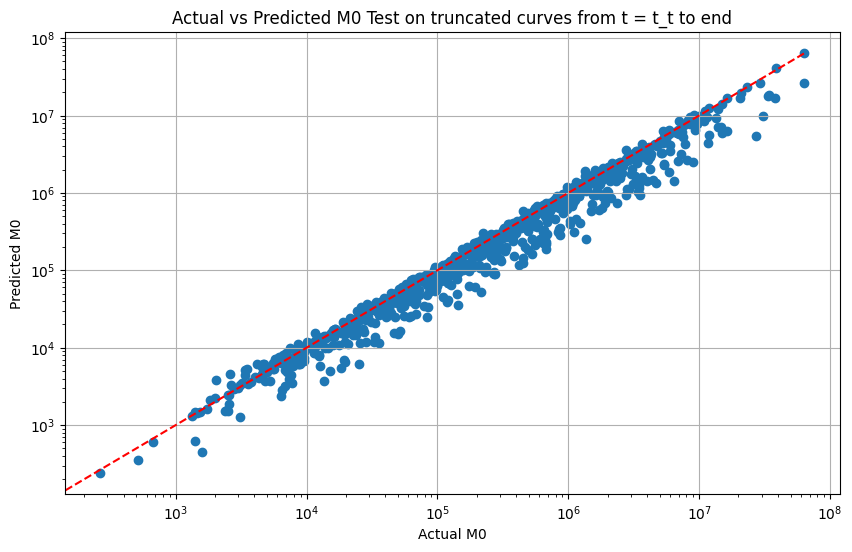

In [ ]:
trunct_time = 1.2
actual_m0 =[]
predicted_m0 =[]

for i in range(actual_curves_nontruncated.shape[0]):
    peak = (np.argmax(actual_curves_nontruncated[i,:]))
    actual_m0.append(np.trapezoid(actual_curves_nontruncated[i,peak:],t_reshape[0,peak:]))
    predicted_m0.append(np.trapezoid(smooth_peak(predicted_curves_nontruncated[i,peak:]),t_reshape[0,peak:]))

actual_m0 = np.array(actual_m0)
predicted_m0 = np.array(predicted_m0)

# R2
r2_m0 = r2_score(actual_m0, predicted_m0)
print(f'R² Score for M0: {r2_m0:.6f}')


# MAPE
mape = np.mean(np.abs((predicted_m0 - actual_m0) / actual_m0)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m0
y_pred = predicted_m0
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x3 = np.linspace(0, np.max(actual_m0)+100)
y3=x3
plt.figure(figsize=(10, 6))
plt.scatter(actual_m0,predicted_m0)
plt.plot(x3,y3,linestyle='--', color='r')
plt.ylabel('Predicted M0')
plt.xlabel('Actual M0')

plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

# Metrics first half

R² Score for M0: 0.983003
R² Score (normalized independently by max): 0.976253
MAPE (%) respecto a 1:1: 6.378884504437132
Bias ratio: 0.982


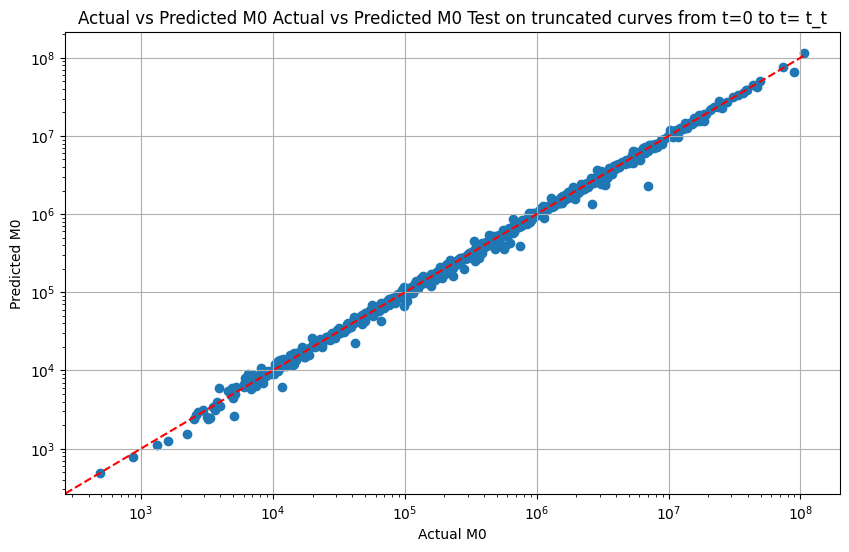

In [ ]:
trunct_time = 1.2
actual_m0 =[]
predicted_m0 =[]

for i in range(actual_curves_nontruncated.shape[0]):
    peak = int(trunct_time*(np.argmax(actual_curves_nontruncated[i,:])))
    actual_m0.append(np.trapezoid(actual_curves_nontruncated[i,0:peak],t_reshape[0,0:peak]))
    predicted_m0.append(np.trapezoid(smooth_peak(predicted_curves_nontruncated[i,0:peak]),t_reshape[0,0:peak]))

actual_m0 = np.array(actual_m0)
predicted_m0 = np.array(predicted_m0)

# R2
r2_m0 = r2_score(actual_m0, predicted_m0)
print(f'R² Score for M0: {r2_m0:.6f}')

# MAPE
mape = np.mean(np.abs((predicted_m0 - actual_m0) / actual_m0)) * 100
print("MAPE (%) respecto a 1:1:", mape)

# BAIAS RATIO
y_true = actual_m0
y_pred = predicted_m0
bias_ratio = np.mean(y_pred) / np.mean(y_true)
print(f"Bias ratio: {bias_ratio:.3f}")

x3 = np.linspace(0, np.max(actual_m0)+100)
y3=x3
plt.figure(figsize=(10, 6))
plt.scatter(actual_m0,predicted_m0)
plt.plot(x3,y3,linestyle='--', color='r')
plt.ylabel('Predicted M0')
plt.xlabel('Actual M0')

plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()